In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import regex as re
import matplotlib.pyplot as plt
from datetime import timedelta
import statsmodels.api as sm
import gc  # For garbage collection
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import os
from itertools import combinations
import pytz
import pickle

In [4]:
df = pd.read_parquet('Data/crypto.parquet')
df.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Trades,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Trades,SOL_Open,SOL_High,SOL_Low,SOL_Close,SOL_Volume,SOL_Trades
timestamp,,,,,,,,,,,,,,,,,,
2021-06-17 15:33:00+00:00,38968.5,38970.0,38944.6,38970.0,0.652743,17,2406.21,2407.00,2406.21,2407.00,75.670235,34,40.23,40.23,40.23,40.23,5.415190,2
2021-06-17 15:35:00+00:00,39036.6,39040.5,38942.6,38942.6,25.647636,84,2409.39,2409.39,2408.00,2408.00,22.743571,11,40.24,40.24,40.24,40.24,21.682209,2
2021-06-17 15:36:00+00:00,38975.9,38975.9,38937.1,38944.5,0.597316,15,2406.51,2406.51,2404.24,2404.24,31.706737,5,40.24,40.24,40.24,40.24,0.200000,1
2021-06-17 15:37:00+00:00,38951.6,38964.1,38945.1,38945.1,0.292383,9,2404.14,2404.15,2404.14,2404.15,0.876316,4,40.25,40.25,40.15,40.15,2.784472,4
2021-06-17 15:38:00+00:00,38958.6,38964.0,38958.0,38961.6,0.105137,6,2405.84,2409.29,2405.74,2409.29,10.159546,26,40.29,40.29,40.29,40.29,20.000000,1


In [ ]:
end_date = dt.datetime.today()
start_date = dt.datetime(2021,1,1,0,0,0,0)
start_date = start_date.replace(tzinfo=pytz.UTC)

df = df[df.index > start_date]
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC')
else:
    df.index = df.index.tz_convert('UTC')
crypto_df = df.copy()

crypto_df = crypto_df.fillna(method='ffill')
crypto_df.dropna(inplace=True)
asset_list = ['BTC', 'ETH']

C:\Users\harri\AppData\Local\Temp\ipykernel_29172\3552787512.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crypto_df = crypto_df.fillna(method='ffill')


In [14]:
windows = [5, 15, 30, 60, 120, 240]

# Create features for each asset individually
for asset in asset_list:
    # Define column names
    close_col = f'{asset}_Close'
    high_col = f'{asset}_High'
    low_col = f'{asset}_Low'
    open_col = f'{asset}_Open'
    volume_col = f'{asset}_Volume'
    trades_col = f'{asset}_Trades'
    
    # Basic log return
    crypto_df[f'{asset}_Log_Return_1m'] = np.log(crypto_df[close_col] / crypto_df[close_col].shift(1))
    
    # Technical indicators and statistical features
    for window in windows:
        # Rolling statistical metrics on Close price
        crypto_df[f'{asset}_Rolling_Mean_{window}'] = crypto_df[close_col].rolling(window=window).mean()
        crypto_df[f'{asset}_Rolling_Median_{window}'] = crypto_df[close_col].rolling(window=window).median()
        crypto_df[f'{asset}_Rolling_STD_{window}'] = crypto_df[close_col].rolling(window=window).std()
        crypto_df[f'{asset}_Rolling_Var_{window}'] = crypto_df[close_col].rolling(window=window).var()
        crypto_df[f'{asset}_Rolling_Skew_{window}'] = crypto_df[close_col].rolling(window=window).skew()
        crypto_df[f'{asset}_Rolling_Kurt_{window}'] = crypto_df[close_col].rolling(window=window).kurt()
        crypto_df[f'{asset}_Rolling_Min_{window}'] = crypto_df[close_col].rolling(window=window).min()
        crypto_df[f'{asset}_Rolling_Max_{window}'] = crypto_df[close_col].rolling(window=window).max()
        crypto_df[f'{asset}_Rolling_Q25_{window}'] = crypto_df[close_col].rolling(window=window).quantile(0.25)
        crypto_df[f'{asset}_Rolling_Q75_{window}'] = crypto_df[close_col].rolling(window=window).quantile(0.75)
        crypto_df[f'{asset}_Rolling_IQR_{window}'] = (
            crypto_df[f'{asset}_Rolling_Q75_{window}'] - crypto_df[f'{asset}_Rolling_Q25_{window}']
        )
        crypto_df[f'{asset}_Rolling_MAD_{window}'] = crypto_df[close_col].rolling(window=window).apply(
            lambda x: np.median(np.abs(x - np.median(x))), raw=True
        )
        
        # Exponential moving average (EMA)
        crypto_df[f'{asset}_EMA_{window}'] = crypto_df[close_col].ewm(span=window, adjust=False).mean()
        
        # Rolling returns
        crypto_df[f'{asset}_Return_{window}m'] = crypto_df[close_col].pct_change(periods=window)
        crypto_df[f'{asset}_Log_Return_{window}m'] = np.log(crypto_df[close_col] / crypto_df[close_col].shift(window))
        
        # Bollinger Bands
        crypto_df[f'{asset}_BB_Upper_{window}'] = (
            crypto_df[f'{asset}_Rolling_Mean_{window}'] + 2 * crypto_df[f'{asset}_Rolling_STD_{window}']
        )
        crypto_df[f'{asset}_BB_Lower_{window}'] = (
            crypto_df[f'{asset}_Rolling_Mean_{window}'] - 2 * crypto_df[f'{asset}_Rolling_STD_{window}']
        )
        
        # Relative Strength Index (RSI)
        delta = crypto_df[close_col].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, -0.0)
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        rs = avg_gain / avg_loss
        crypto_df[f'{asset}_RSI_{window}'] = 100 - (100 / (1 + rs))
        
        # Rolling statistical metrics on Volume
        crypto_df[f'{asset}_Volume_Mean_{window}'] = crypto_df[volume_col].rolling(window=window).mean()
        crypto_df[f'{asset}_Volume_STD_{window}'] = crypto_df[volume_col].rolling(window=window).std()
        crypto_df[f'{asset}_Volume_Min_{window}'] = crypto_df[volume_col].rolling(window=window).min()
        crypto_df[f'{asset}_Volume_Max_{window}'] = crypto_df[volume_col].rolling(window=window).max()
        
        # Rolling statistical metrics on Trades
        crypto_df[f'{asset}_Trades_Mean_{window}'] = crypto_df[trades_col].rolling(window=window).mean()
        crypto_df[f'{asset}_Trades_STD_{window}'] = crypto_df[trades_col].rolling(window=window).std()
        crypto_df[f'{asset}_Trades_Min_{window}'] = crypto_df[trades_col].rolling(window=window).min()
        crypto_df[f'{asset}_Trades_Max_{window}'] = crypto_df[trades_col].rolling(window=window).max()
    
    # Volume and trades percentage change
    crypto_df[f'{asset}_Volume_Change'] = crypto_df[volume_col].pct_change()
    crypto_df[f'{asset}_Trades_Change'] = crypto_df[trades_col].pct_change()

# Create features that capture relationships between different assets
asset_pairs = list(combinations(asset_list, 2))

for asset1, asset2 in asset_pairs:
    close_col1 = f'{asset1}_Close'
    close_col2 = f'{asset2}_Close'
    
    # Price spread and ratio
    crypto_df[f'{asset1}_{asset2}_Price_Spread'] = crypto_df[close_col1] - crypto_df[close_col2]
    crypto_df[f'{asset1}_{asset2}_Price_Ratio'] = crypto_df[close_col1] / crypto_df[close_col2]
    
    # Difference in returns
    ret_col1 = f'{asset1}_Log_Return_1m'
    ret_col2 = f'{asset2}_Log_Return_1m'
    crypto_df[f'{asset1}_{asset2}_Return_Diff'] = crypto_df[ret_col1] - crypto_df[ret_col2]
    
    # Rolling correlation and covariance
    for window in windows:
        crypto_df[f'{asset1}_{asset2}_Rolling_Corr_{window}'] = (
            crypto_df[close_col1].rolling(window=window).corr(crypto_df[close_col2])
        )
        crypto_df[f'{asset1}_{asset2}_Rolling_Cov_{window}'] = (
            crypto_df[close_col1].rolling(window=window).cov(crypto_df[close_col2])
        )
    
    # Rolling beta (regression coefficient)
    for window in windows:
        covariance = crypto_df[f'{asset1}_{asset2}_Rolling_Cov_{window}']
        variance = crypto_df[close_col2].rolling(window=window).var()
        crypto_df[f'{asset1}_Beta_{asset2}_{window}'] = covariance / variance

# Drop rows with NaN values resulting from calculations
crypto_df.dropna(inplace=True)


C:\Users\harri\AppData\Local\Temp\ipykernel_29172\972787340.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crypto_df[f'{asset}_Volume_STD_{window}'] = crypto_df[volume_col].rolling(window=window).std()
C:\Users\harri\AppData\Local\Temp\ipykernel_29172\972787340.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crypto_df[f'{asset}_Volume_Min_{window}'] = crypto_df[volume_col].rolling(window=window).min()
C:\Users\harri\AppData\Local\Temp\ipykernel_29172\972787340.py:64: PerformanceWarning: DataFrame is highly fragmented.

In [17]:
future_windows = [5]

# Create target variables for each asset
for asset in asset_list:
    close_col = f'{asset}_Close'

    for future_window in future_windows:
        # Future percentage return
        crypto_df[f'{asset}_Future_Return_{future_window}m'] = (
            crypto_df[close_col].shift(-future_window) / crypto_df[close_col] - 1
        )

        # Future log return
        crypto_df[f'{asset}_Future_Log_Return_{future_window}m'] = np.log(
            crypto_df[close_col].shift(-future_window) / crypto_df[close_col]
        )

        # Future price direction (classification target)
        crypto_df[f'{asset}_Future_Direction_{future_window}m'] = (
            crypto_df[f'{asset}_Future_Return_{future_window}m'] > 0
        ).astype(int)

        # Future EMA (regression target)
        for window in windows:
            ema_col = f'{asset}_EMA_{window}'
            if ema_col in crypto_df.columns:
                crypto_df[f'{asset}_Future_EMA_{window}_{future_window}m'] = crypto_df[ema_col].shift(-future_window)

asset_pairs = list(combinations(asset_list, 2))

# Create target variables for asset pairs
for asset1, asset2 in asset_pairs:
    close_col1 = f'{asset1}_Close'
    close_col2 = f'{asset2}_Close'

    for future_window in future_windows:
        # Future return difference
        crypto_df[f'{asset1}_{asset2}_Future_Return_Diff_{future_window}m'] = (
            crypto_df[f'{asset1}_Future_Return_{future_window}m'] - crypto_df[f'{asset2}_Future_Return_{future_window}m']
        )

        # Future price spread
        crypto_df[f'{asset1}_{asset2}_Future_Price_Spread_{future_window}m'] = (
            crypto_df[close_col1].shift(-future_window) - crypto_df[close_col2].shift(-future_window)
        )

        # Future price ratio
        crypto_df[f'{asset1}_{asset2}_Future_Price_Ratio_{future_window}m'] = (
            crypto_df[close_col1].shift(-future_window) / crypto_df[close_col2].shift(-future_window)
        )

        # Future outperformance indicator (classification target)
        crypto_df[f'{asset1}_Outperforms_{asset2}_{future_window}m'] = (
            crypto_df[f'{asset1}_Future_Return_{future_window}m'] > crypto_df[f'{asset2}_Future_Return_{future_window}m']
        ).astype(int)


C:\Users\harri\AppData\Local\Temp\ipykernel_29172\3946319539.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crypto_df[f'{asset}_Future_Return_{future_window}m'] = (
C:\Users\harri\AppData\Local\Temp\ipykernel_29172\3946319539.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crypto_df[f'{asset}_Future_Log_Return_{future_window}m'] = np.log(
C:\Users\harri\AppData\Local\Temp\ipykernel_29172\3946319539.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [18]:
crypto_df.replace([np.inf, -np.inf], np.nan, inplace=True)
crypto_df.dropna(inplace=True)

In [19]:
crypto_df.to_pickle('crypto.pkl')
##It is recommended to restart your kernel here, removing all currently in use memory

In [2]:
crypto_df = pd.read_pickle('crypto.pkl')

In [4]:
all_columns = crypto_df.columns.tolist()

# Identify target variables (columns containing '_Target_')
target_pattern = re.compile(r'_Future_|_Outperforms_')
target_columns = [col for col in all_columns if target_pattern.search(col)]
true_targets_pattern = re.compile(r'_Future_Direction_|_Outperforms_')
true_targets = [col for col in all_columns if true_targets_pattern.search(col)] 
# Exclude columns that should not be used as features
exclude_columns = []
#for asset in asset_list:
#   exclude_columns.extend([
 #     f'{asset}_Open', f'{asset}_High', f'{asset}_Low', f'{asset}_Close',
 #      f'{asset}_Volume', f'{asset}_Trades'
#   ])
exclude_columns.extend(target_columns)

feature_columns = [col for col in all_columns if col not in exclude_columns]

X_len = len(crypto_df[crypto_df.index < '2024-01-01'])
X_portion = X_len / len(crypto_df)
results = []
y_pred_list = []
y_proba_list = []

In [41]:
models = {}
# Iterate over each target variable
for target_var in true_targets:
    print(f"\nProcessing target variable: {target_var}")
    
    try:
        X = crypto_df[feature_columns]
        y = crypto_df[target_var]
        
        # Determine if the target is for classification or regression
        unique_values = y.unique()
        if y.dtype == 'object' or y.dtype == 'bool':
            problem_type = 'classification'
        elif len(unique_values) <= 10 and y.dtype != 'float':
            problem_type = 'classification'
        elif np.array_equal(np.sort(unique_values), [0, 1]):
            problem_type = 'classification'
        else:
            problem_type = 'regression'
        # Split the data (time series split)
        X_train, X_test = X.iloc[:X_len], X.iloc[X_len:]
        y_train, y_test = y.iloc[:X_len], y.iloc[X_len:]
        # Check if we have enough data after splitting
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data to train model for target {target_var}.")
            continue
        
        if problem_type == 'classification':
            # Initialize XGBoost classifier
            model = xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                subsample=X_portion,
                colsample_bytree=0.8,
                random_state=42,
                use_label_encoder=False,
                eval_metric='logloss'
            )
            
            # Fit the model
            model.fit(X_train, y_train)

            models[target_var] = model

            with open(f'{target_var}_model.pkl', 'wb') as f:
                pickle.dump(model, f)
            
            # Predict and evaluate
            y_pred = model.predict(X_test)
            y_pred2 = model.predict(X)
            y_pred_list.append(y_pred2)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_proba2 = model.predict_proba(X)[:, 1]
            y_proba_list.append(y_proba2)
            # Compute metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, y_proba)
            
            #Store results
            results.append({
                'Target Variable': target_var,
                'Problem Type': problem_type,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'ROC AUC': roc_auc
            })
            
            #Output metrics
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")
            
        else:
            print(f"Unknown problem type for target {target_var}")
            continue
        
    except Exception as e:
        print(f"An error occurred while processing {target_var}: {e}")
    
    # Delete variables to free up memory
    del X, y, X_train, X_test, y_train, y_test, model
    del y_pred
    del y_pred2
    if problem_type == 'classification':
        del y_proba
        del y_proba2
    # Force garbage collection
    gc.collect()
    
# Convert results to DataFrame for better visualizatio
results_df = pd.DataFrame(results)
# Display the result
print("\nSummary of Results:")
print(results_df)



Processing target variable: BTC_Future_Direction_5m
Accuracy: 0.5424
Precision: 0.5492
Recall: 0.4687
F1 Score: 0.5058
ROC AUC: 0.5626

Processing target variable: ETH_Future_Direction_5m
Accuracy: 0.5357
Precision: 0.5319
Recall: 0.6203
F1 Score: 0.5727
ROC AUC: 0.5515

Processing target variable: BTC_Outperforms_ETH_5m
Accuracy: 0.5461
Precision: 0.5602
Recall: 0.4907
F1 Score: 0.5232
ROC AUC: 0.5687

Summary of Results:
           Target Variable    Problem Type  Accuracy  Precision    Recall  \
0  BTC_Future_Direction_5m  classification  0.542373   0.549226  0.468715   
1  ETH_Future_Direction_5m  classification  0.535737   0.531883  0.620254   
2   BTC_Outperforms_ETH_5m  classification  0.546079   0.560210  0.490690   
3  BTC_Future_Direction_5m  classification  0.542373   0.549226  0.468715   
4  ETH_Future_Direction_5m  classification  0.535737   0.531883  0.620254   
5   BTC_Outperforms_ETH_5m  classification  0.546079   0.560210  0.490690   

   F1 Score   ROC AUC  
0  0.505

In [62]:
target_var = 'BTC_Future_Direction_5m'
X = crypto_df[feature_columns]
y = crypto_df[target_var]

X_train, X_test = X.iloc[:X_len], X.iloc[X_len:]
y_train, y_test = y.iloc[:X_len], y.iloc[X_len:]

model = pd.read_pickle('BTC_Future_Direction_5m_model.pkl')

In [63]:
tree_dump = model.get_booster().get_dump()
print(len(tree_dump))

100


In [64]:
from xgboost import to_graphviz

graph = xgb.to_graphviz(model, num_trees=50)
graph.render('btc_xgboost_tree', format='pdf')
graph.view()

'btc_xgboost_tree.pdf'

In [65]:
import shap

X_sample = shap.sample(X_train, nsamples=100, random_state=42)

# ETH Future Direction 5m - Shap Explainer

explainer = shap.Explainer(model, X_sample)

X_test_sample = shap.sample(X_test, nsamples=100, random_state=42)
shap_values = explainer(X_test_sample)

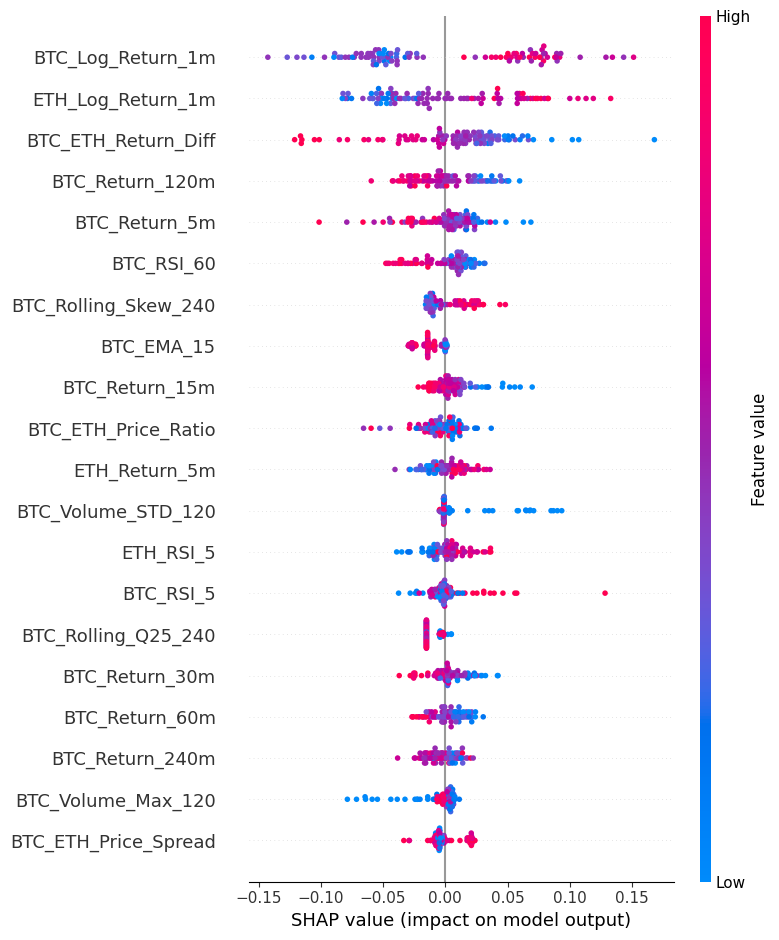

In [66]:
shap.summary_plot(shap_values, X_test_sample)

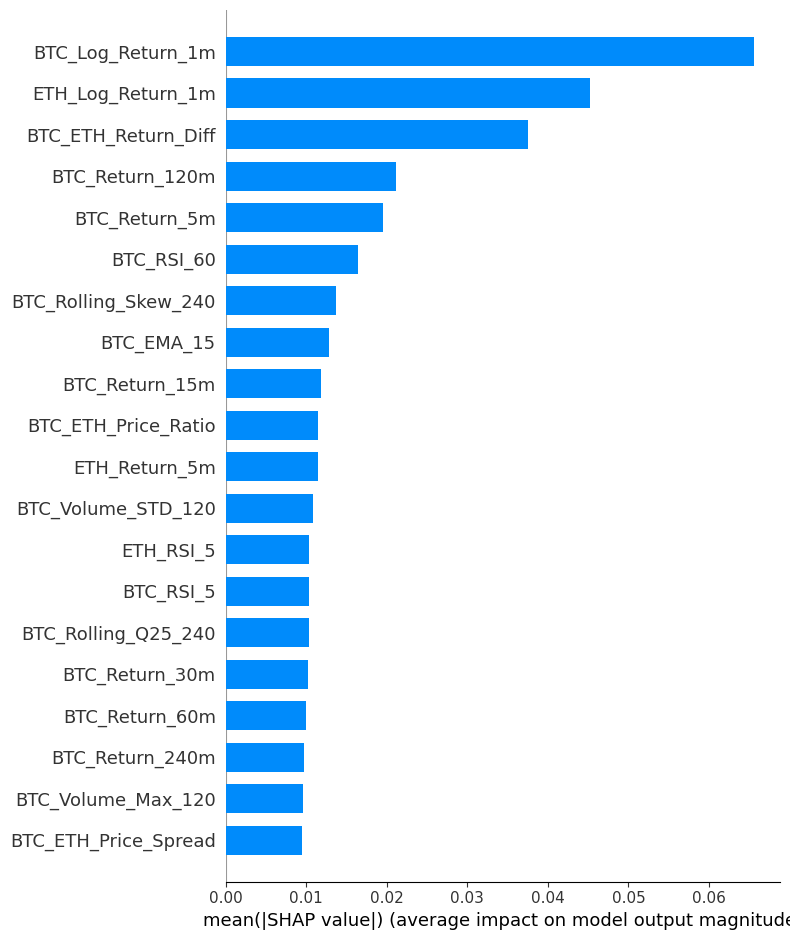

In [67]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [69]:
shap_df = pd.DataFrame(np.abs(shap_values.values), columns=X_test.columns)
shap_df['mean_shap'] = shap_df.mean(axis=1)

important_features = shap_df.mean().sort_values(ascending=False)
important_features = important_features[important_features > 0.011]
important_features_list = important_features.index.tolist()
important_features

BTC_Log_Return_1m       0.065541
ETH_Log_Return_1m       0.045201
BTC_ETH_Return_Diff     0.037545
BTC_Return_120m         0.021110
BTC_Return_5m           0.019538
BTC_RSI_60              0.016418
BTC_Rolling_Skew_240    0.013662
BTC_EMA_15              0.012836
BTC_Return_15m          0.011836
BTC_ETH_Price_Ratio     0.011417
ETH_Return_5m           0.011412
dtype: float64

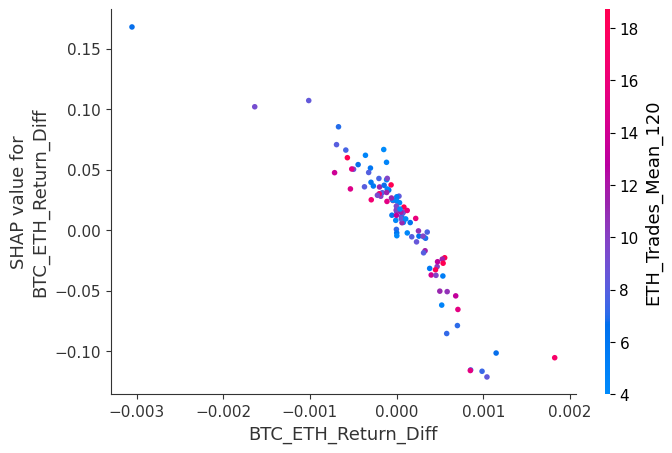

In [70]:
shap.dependence_plot("BTC_ETH_Return_Diff", shap_values.values, X_test_sample)

In [23]:
newdf = crypto_df[['BTC_Close', 'BTC_Low', 'BTC_High', 'ETH_Close', 'ETH_Low', 'ETH_High']].copy()
i = 0
while i < len(true_targets):
    newdf[true_targets[i]] = y_pred_list[i]
    newdf[f'{true_targets[i]}_Proba'] = y_proba_list[i]
    i+=1
newdf.to_pickle("full_trading.pkl")

In [77]:
def calculate_metrics(df, returns_column, benchmark_returns_column=None):
    """
    Calculate performance metrics for a given returns series.
    
    Parameters:
    - df: DataFrame containing the returns data.
    - returns_column: Column name for the strategy returns.
    - benchmark_returns_column: Column name for the benchmark returns (if any).
    
    Returns:
    - metrics: Dictionary of calculated metrics.
    """
    # Calculate cumulative returns
    df['Cumulative_Returns'] = (1 + df[returns_column]).cumprod()
    
    # Calculate total time period in years
    total_days = (df.index[-1] - df.index[0]).total_seconds() / (3600 * 24)
    total_years = total_days / 365.25  # Accounting for leap years
    
    ## Metrics Calculation ##
    
    # Total Return
    total_return = df['Cumulative_Returns'].iloc[-1] - 1
    annualized_return = (1 + total_return) ** (1 / total_years) - 1
    
    # Number of Transactions (if 'Trade' column exists)
    if 'Trade' in df.columns and returns_column == 'Strategy_Returns':
        num_transactions = df['Trade'].sum()
    else:
        num_transactions = np.nan  # Not applicable for benchmark
    
    # Average Gain/Loss per Transaction
    if 'Trade' in df.columns and returns_column == 'Strategy_Returns':
        trades = df[df['Trade'] == 1]
        trade_indices = trades.index
        trade_profits = []
        
        for i in range(1, len(trade_indices)):
            start_index = trade_indices[i-1]
            end_index = trade_indices[i]
            profit = df.loc[end_index, 'Position'] - df.loc[start_index, 'Position']
            trade_profits.append(profit)
        if trade_profits:
            avg_gain_loss = np.mean(trade_profits)
        else:
            avg_gain_loss = 0
    else:
        avg_gain_loss = np.nan  # Not applicable for benchmark
    
    # Maximum Drawdown
    rolling_max = df['Cumulative_Returns'].cummax()
    drawdown = (df['Cumulative_Returns'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Annualized Sharpe Ratio
    risk_free_rate = 0  # Assuming zero risk-free rate
    periods_per_year = 365.25 * 24 * 60  # Total minutes in a year
    mean_return = df[returns_column].mean() * periods_per_year
    std_return = df[returns_column].std() * np.sqrt(periods_per_year)
    if std_return != 0:
        sharpe_ratio = (mean_return - risk_free_rate) / std_return
    else:
        sharpe_ratio = np.nan
    
    # Tracking Error and Information Ratio (if benchmark returns are provided)
    if benchmark_returns_column:
        df['Excess_Returns'] = df[returns_column] - df[benchmark_returns_column]
        tracking_error = df['Excess_Returns'].std() * np.sqrt(periods_per_year)
        mean_excess_return = df['Excess_Returns'].mean() * periods_per_year
        if tracking_error != 0:
            information_ratio = mean_excess_return / tracking_error
        else:
            information_ratio = np.nan
    else:
        tracking_error = np.nan
        information_ratio = np.nan
    
    # Treynor Ratio and Jensen's Alpha (Require Beta estimation)
    if benchmark_returns_column:
        df.dropna(subset=[returns_column, benchmark_returns_column], inplace=True)
        X = df[benchmark_returns_column]
        y = df[returns_column]
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        model = sm.OLS(y, X).fit()
        beta = model.params[benchmark_returns_column]
        
        if beta != 0:
            treynor_ratio = (mean_return - risk_free_rate) / beta
        else:
            treynor_ratio = np.nan
        mean_benchmark_return = df[benchmark_returns_column].mean() * periods_per_year
        jensens_alpha = mean_return - (risk_free_rate + beta * (mean_benchmark_return - risk_free_rate))
    else:
        beta = np.nan
        treynor_ratio = np.nan
        jensens_alpha = np.nan
    
    ## Metrics Summary ##
    metrics = {
        'Total Return': f"{total_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Number of Transactions': f"{int(num_transactions) if not np.isnan(num_transactions) else 'N/A'}",
        'Average Gain/Loss per Transaction': f"${avg_gain_loss:,.2f}" if not np.isnan(avg_gain_loss) else 'N/A',
        'Maximum Drawdown': f"{max_drawdown:.2%}",
        'Annualized Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Tracking Error': f"{tracking_error:.2%}" if not np.isnan(tracking_error) else 'N/A',
        'Information Ratio': f"{information_ratio:.2f}" if not np.isnan(information_ratio) else 'N/A',
        'Treynor Ratio': f"{treynor_ratio:.2f}" if not np.isnan(treynor_ratio) else 'N/A',
        'Jensen\'s Alpha': f"{jensens_alpha:.2%}" if not np.isnan(jensens_alpha) else 'N/A'
    }
    
    return metrics

def analyze_strategies(df):
    # Ensure 'Position' and 'Pos_Benchmark' are numeric
    df['Position'] = pd.to_numeric(df['Position'], errors='coerce')
    df['Pos_Benchmark'] = pd.to_numeric(df['Pos_Benchmark'], errors='coerce')
    
    # Calculate Strategy Returns
    df['Strategy_Returns'] = df['Position'].pct_change()
    
    # Calculate Benchmark Returns
    df['Benchmark_Returns'] = df['Pos_Benchmark'].pct_change()
    
    # Metrics for Strategy
    strategy_metrics = calculate_metrics(df.copy(), 'Strategy_Returns', 'Benchmark_Returns')
    
    # Metrics for Benchmark
    benchmark_metrics = calculate_metrics(df.copy(), 'Benchmark_Returns')
    
    # Combine metrics into a DataFrame for better formatting
    metrics_df = pd.DataFrame({
        'Metric': strategy_metrics.keys(),
        'Strategy': strategy_metrics.values(),
        'Benchmark': benchmark_metrics.values()
    })
    
    # Set 'Metric' as the index
    metrics_df.set_index('Metric', inplace=True)
    
    ## Visualizations ##
    # Cumulative Performance Chart
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, (1 + df['Strategy_Returns']).cumprod(), label='Strategy')
    plt.plot(df.index, (1 + df['Benchmark_Returns']).cumprod(), label='Benchmark')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
    
    # Returns Distribution for Strategy
    plt.figure(figsize=(10, 5))
    df['Strategy_Returns'].hist(bins=50)
    plt.title('Strategy Returns Distribution')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.show()
    
    return metrics_df

In [17]:
trading_df = pd.read_pickle("full_trading.pkl")

# Single Indicator Strategy

In [ ]:
def simulate_trading_strategy(
    df,
    target_variable,
    initial_capital=10_000_000,
    transaction_cost=0.001,  # 0.1% transaction cost for market orders
    start_date=None,
    end_date=None,
    strategy_params=None
):
    """
    Simulate a trading strategy based on predictions and thresholds, with limit orders and adjusted execution.

    Parameters:
    - df: DataFrame containing close prices, high/low prices, and predictions.
    - target_variable: The name of the target variable (e.g., 'BTC_Future_Direction_5m').
    - initial_capital: Starting capital in USD.
    - transaction_cost: Transaction cost as a proportion (e.g., 0.001 for 0.1%).
    - start_date: Start date for the simulation (string in 'YYYY-MM-DD' format).
    - end_date: End date for the simulation (string in 'YYYY-MM-DD' format).
    - strategy_params: Dictionary of strategy parameters.

    Returns:
    - df: DataFrame with added columns for positions and portfolio value.
    - performance_metrics: Dictionary of performance metrics.
    - trade_history_df: DataFrame of trade history.
    """

    # Set default strategy parameters if not provided
    if strategy_params is None:
        strategy_params = {
            'investment_fraction': 1.0,     # Fraction of capital to invest
            'use_limit_orders': False,      # Whether to use limit orders
            'buy_threshold': 0.6,           # Probability threshold to buy
            'sell_threshold': 0.4,          # Probability threshold to sell
            'limit_order_buffer': 0.001,    # Price buffer for limit orders (e.g., 0.1%)
            'limit_order_duration': 5       # Duration in minutes to wait for limit order execution
        }

    # Filter data based on date range
    if start_date is not None and end_date is not None:
        df = df[(df.index >= start_date) & (df.index <= end_date)].copy()
    else:
        df = df.copy()

    # Initialize variables
    capital = initial_capital
    btc_balance = 0.0
    eth_balance = 0.0
    usd_balance = capital
    position_history = []
    portfolio_value_history = []
    trade_history = []
    holdings_history = []
    transaction_costs_total = 0.0
    trade_list = []  # For the 'Trade' column (1 if a trade occurs, else 0)
    benchmark_position_history = []  # For 'Pos_Benchmark'

    # Pending orders lists
    pending_orders = []
    pending_market_orders = []  # For market orders to be executed at next tick

    # Iterate over each row in the DataFrame
    for idx in range(len(df)):
        row = df.iloc[idx]
        date = df.index[idx]

        # Get high and low prices
        btc_high = row['BTC_High']
        btc_low = row['BTC_Low']
        eth_high = row['ETH_High']
        eth_low = row['ETH_Low']

        # Process pending market orders from previous tick
        if idx > 0:
            previous_row = df.iloc[idx - 1]
            prev_date = df.index[idx - 1]
            orders_to_remove = []
            for order in pending_market_orders:
                asset = order['asset']
                order_type = order['type']
                investment_fraction = order['investment_fraction']
                transaction_fee = 0.0

                # Execution prices at T+1
                if asset == 'BTC':
                    high_price = btc_high
                    low_price = btc_low
                elif asset == 'ETH':
                    high_price = eth_high
                    low_price = eth_low
                else:
                    continue

                # Execute the trade
                if order_type == 'buy':
                    execution_price = high_price  # Use High price for buys
                    investment_amount = usd_balance * investment_fraction
                    transaction_fee = investment_amount * transaction_cost
                    quantity = (investment_amount - transaction_fee) / execution_price
                    usd_balance -= investment_amount
                    if asset == 'BTC':
                        btc_balance += quantity
                    elif asset == 'ETH':
                        eth_balance += quantity
                    trade_action = f'buy_{asset.lower()}'
                elif order_type == 'sell':
                    execution_price = low_price  # Use Low price for sells
                    if asset == 'BTC':
                        proceeds = btc_balance * execution_price
                        quantity = btc_balance
                        btc_balance = 0.0
                    elif asset == 'ETH':
                        proceeds = eth_balance * execution_price
                        quantity = eth_balance
                        eth_balance = 0.0
                    transaction_fee = proceeds * transaction_cost
                    usd_balance += proceeds - transaction_fee
                    trade_action = f'sell_{asset.lower()}'
                transaction_costs_total += transaction_fee
                trade_occurred = 1
                orders_to_remove.append(order)
                trade_history.append({
                    'Date': date,
                    'Action': trade_action,
                    'Asset': asset,
                    'Order Type': order_type,
                    'Execution Price': execution_price,
                    'Quantity': quantity,
                    'Transaction Fee': transaction_fee,
                    'Holdings': {'BTC': btc_balance, 'ETH': eth_balance, 'USD': usd_balance},
                    'Portfolio Value': btc_balance * btc_high + eth_balance * eth_high + usd_balance
                })
                trade_list.append(trade_occurred)
            # Remove executed orders
            for order in orders_to_remove:
                pending_market_orders.remove(order)

        # Get prediction and prediction probability
        prediction = row[target_variable]
        proba_column = f'{target_variable}_Proba'
        if proba_column in df.columns:
            prediction_proba = row[proba_column]
        else:
            # If probabilities are not provided, use default probabilities
            prediction_proba = 1.0 if prediction == 1 else 0.0

        # Determine current positions
        total_value = btc_balance * btc_high + eth_balance * eth_high + usd_balance

        # Initialize trade action
        trade_action = 'hold'
        trade_occurred = 0  # 1 if a trade occurs

        # Process pending limit orders
        orders_to_remove = []
        for order in pending_orders:
            asset = order['asset']
            order_type = order['type']
            limit_price = order['limit_price']
            order_time = order['time']
            duration = strategy_params['limit_order_duration']
            time_diff = (date - order_time).total_seconds() / 60  # Time difference in minutes

            # Skip if order duration has not yet passed
            if time_diff < duration:
                continue
            else:
                # Cancel the order
                orders_to_remove.append(order)
                continue

        # Remove canceled orders
        for order in orders_to_remove:
            pending_orders.remove(order)

        # Process limit orders for execution at T+1
        if idx < len(df) - 1:
            next_row = df.iloc[idx + 1]
            next_date = df.index[idx + 1]
            orders_to_remove = []
            for order in pending_orders:
                asset = order['asset']
                order_type = order['type']
                limit_price = order['limit_price']

                # Get High/Low prices at T+1
                if asset == 'BTC':
                    next_high_price = next_row['BTC_High']
                    next_low_price = next_row['BTC_Low']
                elif asset == 'ETH':
                    next_high_price = next_row['ETH_High']
                    next_low_price = next_row['ETH_Low']
                else:
                    continue

                price_reached = False

                if order_type == 'buy' and next_high_price >= limit_price:
                    price_reached = True
                elif order_type == 'sell' and next_low_price <= limit_price:
                    price_reached = True

                if price_reached:
                    # Execute the trade at the execution price (High for buys, Low for sells)
                    if order_type == 'buy':
                        execution_price = next_high_price  # Use High price at T+1 for buys
                        investment_amount = usd_balance * strategy_params['investment_fraction']
                        transaction_fee = 0.0  # Assuming limit orders have zero transaction cost
                        quantity = investment_amount / execution_price
                        usd_balance -= investment_amount
                        if asset == 'BTC':
                            btc_balance += quantity
                        elif asset == 'ETH':
                            eth_balance += quantity
                        trade_action = f'limit_buy_{asset.lower()}'
                    elif order_type == 'sell':
                        execution_price = next_low_price  # Use Low price at T+1 for sells
                        if asset == 'BTC':
                            proceeds = btc_balance * execution_price
                            quantity = btc_balance
                            btc_balance = 0.0
                        elif asset == 'ETH':
                            proceeds = eth_balance * execution_price
                            quantity = eth_balance
                            eth_balance = 0.0
                        transaction_fee = 0.0  # Assuming limit orders have zero transaction cost
                        usd_balance += proceeds
                        trade_action = f'limit_sell_{asset.lower()}'
                    transaction_costs_total += transaction_fee
                    trade_occurred = 1
                    orders_to_remove.append(order)
                    trade_history.append({
                        'Date': next_date,
                        'Action': trade_action,
                        'Asset': asset,
                        'Order Type': order_type,
                        'Execution Price': execution_price,
                        'Quantity': quantity,
                        'Transaction Fee': transaction_fee,
                        'Holdings': {'BTC': btc_balance, 'ETH': eth_balance, 'USD': usd_balance},
                        'Portfolio Value': btc_balance * next_high_price + eth_balance * next_high_price + usd_balance
                    })
                    trade_list.append(trade_occurred)
            # Remove executed orders
            for order in orders_to_remove:
                pending_orders.remove(order)

        # Decision-making logic based on target variable
        if strategy_params['use_limit_orders']:
            # Handle limit orders
            if target_variable == 'BTC_Future_Direction_5m':
                # Strategy for BTC future direction
                if prediction_proba >= strategy_params['buy_threshold']:
                    # Place limit buy order if not already holding BTC
                    if btc_balance == 0 and not any(o['asset'] == 'BTC' and o['type'] == 'buy' for o in pending_orders):
                        limit_price = btc_high * (1 + strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'BTC',
                            'type': 'buy',
                            'limit_price': limit_price,
                            'time': date
                        })
                elif prediction_proba <= strategy_params['sell_threshold']:
                    # Place limit sell order if holding BTC
                    if btc_balance > 0 and not any(o['asset'] == 'BTC' and o['type'] == 'sell' for o in pending_orders):
                        limit_price = btc_low * (1 - strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'BTC',
                            'type': 'sell',
                            'limit_price': limit_price,
                            'time': date
                        })
            elif target_variable == 'ETH_Future_Direction_5m':
                # Strategy for ETH future direction
                if prediction_proba >= strategy_params['buy_threshold']:
                    # Place limit buy order if not already holding ETH
                    if eth_balance == 0 and not any(o['asset'] == 'ETH' and o['type'] == 'buy' for o in pending_orders):
                        limit_price = eth_high * (1 + strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'ETH',
                            'type': 'buy',
                            'limit_price': limit_price,
                            'time': date
                        })
                elif prediction_proba <= strategy_params['sell_threshold']:
                    # Place limit sell order if holding ETH
                    if eth_balance > 0 and not any(o['asset'] == 'ETH' and o['type'] == 'sell' for o in pending_orders):
                        limit_price = eth_low * (1 - strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'ETH',
                            'type': 'sell',
                            'limit_price': limit_price,
                            'time': date
                        })
            elif target_variable == 'BTC_Outperforms_ETH_5m':
                # Strategy for BTC outperforming ETH
                if prediction_proba >= strategy_params['buy_threshold']:
                    # Move capital to BTC
                    # Place limit sell order for ETH if holding
                    if eth_balance > 0 and not any(o['asset'] == 'ETH' and o['type'] == 'sell' for o in pending_orders):
                        limit_price = eth_low * (1 - strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'ETH',
                            'type': 'sell',
                            'limit_price': limit_price,
                            'time': date
                        })
                    # Place limit buy order for BTC if not already holding
                    if btc_balance == 0 and not any(o['asset'] == 'BTC' and o['type'] == 'buy' for o in pending_orders):
                        limit_price = btc_high * (1 + strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'BTC',
                            'type': 'buy',
                            'limit_price': limit_price,
                            'time': date
                        })
                elif prediction_proba <= strategy_params['sell_threshold']:
                    # Move capital to ETH
                    # Place limit sell order for BTC if holding
                    if btc_balance > 0 and not any(o['asset'] == 'BTC' and o['type'] == 'sell' for o in pending_orders):
                        limit_price = btc_low * (1 - strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'BTC',
                            'type': 'sell',
                            'limit_price': limit_price,
                            'time': date
                        })
                    # Place limit buy order for ETH if not already holding
                    if eth_balance == 0 and not any(o['asset'] == 'ETH' and o['type'] == 'buy' for o in pending_orders):
                        limit_price = eth_high * (1 + strategy_params['limit_order_buffer'])
                        pending_orders.append({
                            'asset': 'ETH',
                            'type': 'buy',
                            'limit_price': limit_price,
                            'time': date
                        })
        else:
            # Handle market orders (to be executed at next tick)
            if target_variable == 'BTC_Future_Direction_5m':
                # Strategy for BTC future direction
                if prediction_proba >= strategy_params['buy_threshold']:
                    # Queue buy BTC if not already holding
                    if btc_balance == 0 and not any(o['asset'] == 'BTC' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'BTC',
                            'type': 'buy',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
                elif prediction_proba <= strategy_params['sell_threshold']:
                    # Queue sell BTC if holding
                    if btc_balance > 0 and not any(o['asset'] == 'BTC' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'BTC',
                            'type': 'sell',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
            elif target_variable == 'ETH_Future_Direction_5m':
                # Strategy for ETH future direction
                if prediction_proba >= strategy_params['buy_threshold']:
                    # Queue buy ETH if not already holding
                    if eth_balance == 0 and not any(o['asset'] == 'ETH' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'ETH',
                            'type': 'buy',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
                elif prediction_proba <= strategy_params['sell_threshold']:
                    # Queue sell ETH if holding
                    if eth_balance > 0 and not any(o['asset'] == 'ETH' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'ETH',
                            'type': 'sell',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
            elif target_variable == 'BTC_Outperforms_ETH_5m':
                # Strategy for BTC outperforming ETH
                if prediction_proba >= strategy_params['buy_threshold']:
                    # Move capital to BTC
                    # Queue sell ETH if holding
                    if eth_balance > 0 and not any(o['asset'] == 'ETH' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'ETH',
                            'type': 'sell',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
                    # Queue buy BTC if not already holding
                    if btc_balance == 0 and not any(o['asset'] == 'BTC' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'BTC',
                            'type': 'buy',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
                elif prediction_proba <= strategy_params['sell_threshold']:
                    # Move capital to ETH
                    # Queue sell BTC if holding
                    if btc_balance > 0 and not any(o['asset'] == 'BTC' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'BTC',
                            'type': 'sell',
                            'investment_fraction': strategy_params['investment_fraction']
                        })
                    # Queue buy ETH if not already holding
                    if eth_balance == 0 and not any(o['asset'] == 'ETH' for o in pending_market_orders):
                        pending_market_orders.append({
                            'asset': 'ETH',
                            'type': 'buy',
                            'investment_fraction': strategy_params['investment_fraction']
                        })

        # Update holdings and portfolio value
        holdings = {
            'BTC': btc_balance,
            'ETH': eth_balance,
            'USD': usd_balance
        }
        total_value = btc_balance * btc_high + eth_balance * eth_high + usd_balance
        holdings_history.append(holdings)
        portfolio_value_history.append(total_value)
        position_history.append(trade_action)
        # Append 0 to trade_list if no trade occurred in this tick
        if len(trade_list) < idx + 1:
            trade_list.append(0)

        # For benchmark, let's assume a buy-and-hold strategy in BTC
        # Initialize benchmark position at the first timestamp
        if idx == 0:
            benchmark_btc_balance = initial_capital / btc_high
        benchmark_position = benchmark_btc_balance * btc_high
        benchmark_position_history.append(benchmark_position)

    # Add the new columns to the DataFrame
    df['Trade Action'] = position_history
    df['Portfolio Value'] = portfolio_value_history
    df['Position'] = portfolio_value_history
    df['Trade'] = trade_list
    df['Pos_Benchmark'] = benchmark_position_history

    # Prepare performance metrics
    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': portfolio_value_history[-1],
        'Total Return (%)': ((portfolio_value_history[-1] / initial_capital) - 1) * 100,
        'Total Transaction Costs': transaction_costs_total,
        'Number of Trades': sum(trade_list)
    }

    # Convert trade history to DataFrame
    trade_history_df = pd.DataFrame(trade_history)

    # Return the DataFrame and performance metrics
    return df, performance_metrics, trade_history_df


## Strategy Results for Single Indicator with Limit Orders

### BTC Direction Full Sample

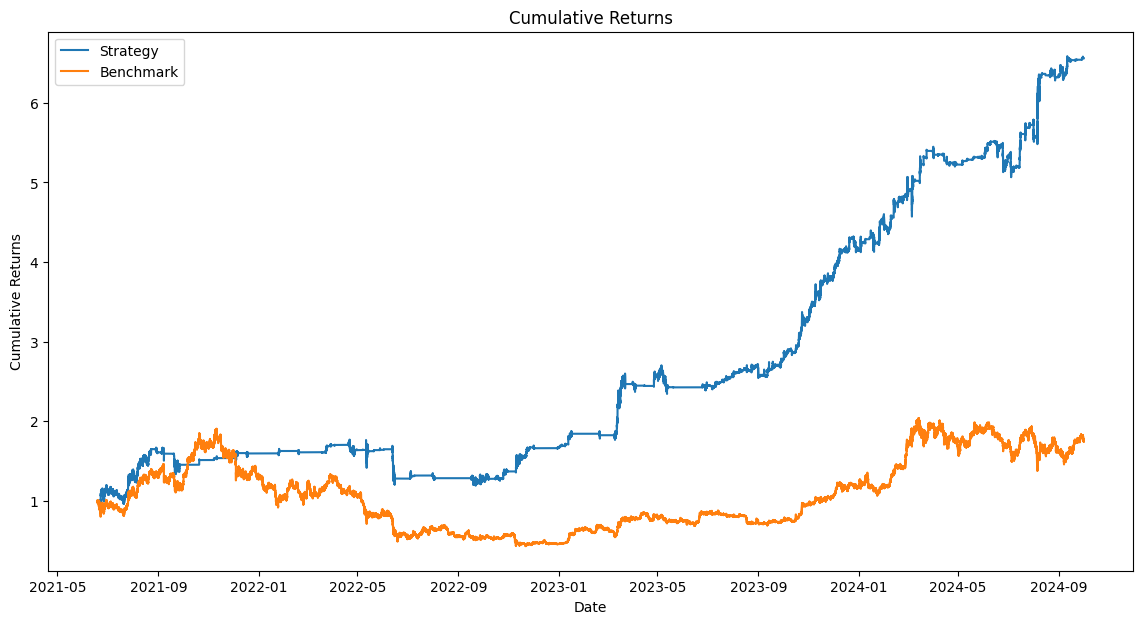

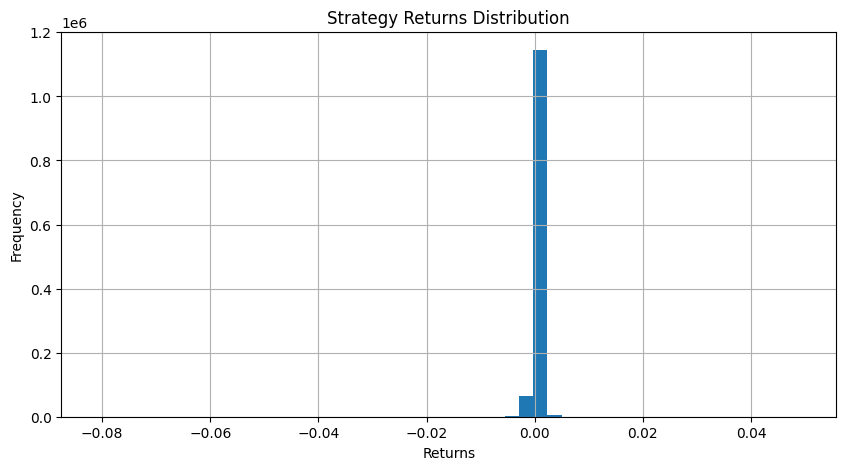

,Strategy,Benchmark
Metric,,
Total Return,556.16%,74.70%
Annualized Return,77.27%,18.50%
Number of Transactions,2088,N/A
Average Gain/Loss per Transaction,"$26,693.96",N/A
Maximum Drawdown,-32.75%,-77.49%
Annualized Sharpe Ratio,2.39,0.70
Tracking Error,52.62%,N/A
Information Ratio,0.82,N/A
Treynor Ratio,2.69,N/A


In [83]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': True,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df,
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


In [86]:
crypto_df.head()

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Trades,ETH_Open,ETH_High,ETH_Low,ETH_Close,...,ETH_Future_EMA_5_5m,ETH_Future_EMA_15_5m,ETH_Future_EMA_30_5m,ETH_Future_EMA_60_5m,ETH_Future_EMA_120_5m,ETH_Future_EMA_240_5m,BTC_ETH_Future_Return_Diff_5m,BTC_ETH_Future_Price_Spread_5m,BTC_ETH_Future_Price_Ratio_5m,BTC_Outperforms_ETH_5m
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-18 18:14:00+00:00,36182.5,36182.5,36177.9,36177.9,0.721968,28,2200.54,2200.55,2195.00,2195.01,...,2171.282242,2194.357163,2211.270685,2233.561494,2265.091194,2303.253755,0.000527,33493.53,16.490701,1
2021-06-18 18:21:00+00:00,36175.0,36182.9,36145.5,36145.5,1.529001,40,2193.15,2194.17,2190.00,2190.01,...,2164.418161,2188.898767,2207.362254,2230.844395,2263.200265,2301.987666,0.000317,33357.31,16.510050,1
2021-06-18 18:29:00+00:00,36000.0,36000.0,35688.8,35735.3,120.634947,736,2173.17,2173.17,2153.08,2158.50,...,2159.538774,2184.008922,2203.647270,2228.186546,2261.325550,2300.724532,-0.005754,33235.52,16.459963,0
2021-06-18 18:33:00+00:00,35771.7,35794.5,35756.1,35765.6,8.614926,46,2167.05,2170.00,2167.05,2170.00,...,2159.485849,2180.930306,2200.791317,2225.930594,2259.640500,2299.551548,-0.002703,33334.52,16.437079,0
2021-06-18 18:35:00+00:00,35800.4,35818.1,35623.0,35646.3,28.217275,184,2171.00,2171.00,2160.66,2163.43,...,2159.757233,2178.351518,2198.178974,2223.778771,2257.998508,2298.395934,-0.001771,33371.30,16.447530,0


In [84]:
trading_df.head()

,BTC_Close,BTC_Low,BTC_High,ETH_Close,ETH_Low,ETH_High,BTC_Future_Direction_5m,BTC_Future_Direction_5m_Proba,ETH_Future_Direction_5m,ETH_Future_Direction_5m_Proba,BTC_Outperforms_ETH_5m,BTC_Outperforms_ETH_5m_Proba
timestamp,,,,,,,,,,,,
2021-06-18 18:14:00+00:00,36177.9,36177.9,36182.5,2195.01,2195.00,2200.55,1,0.553880,1,0.558492,0,0.433347
2021-06-18 18:21:00+00:00,36145.5,36145.5,36182.9,2190.01,2190.00,2194.17,1,0.547530,1,0.563565,0,0.414473
2021-06-18 18:29:00+00:00,35735.3,35688.8,36000.0,2158.50,2153.08,2173.17,1,0.568927,1,0.611266,0,0.387591
2021-06-18 18:33:00+00:00,35765.6,35756.1,35794.5,2170.00,2167.05,2170.00,1,0.562875,1,0.554401,1,0.511299
2021-06-18 18:35:00+00:00,35646.3,35623.0,35818.1,2163.43,2160.66,2171.00,1,0.570308,1,0.578087,0,0.462612


### BTC Direction OOS Only

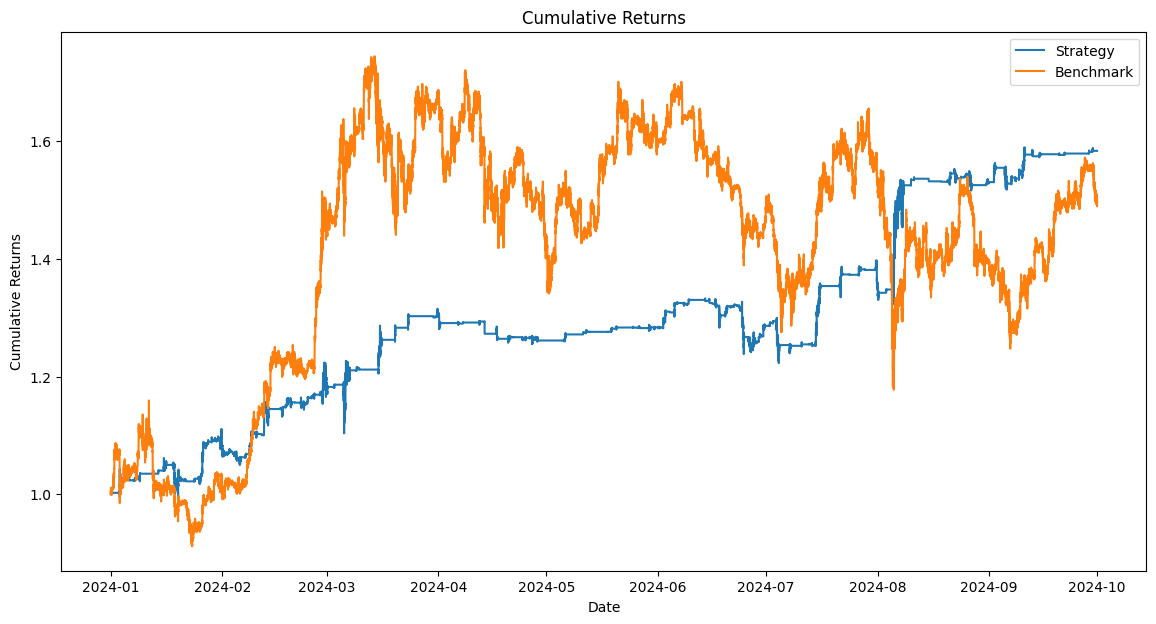

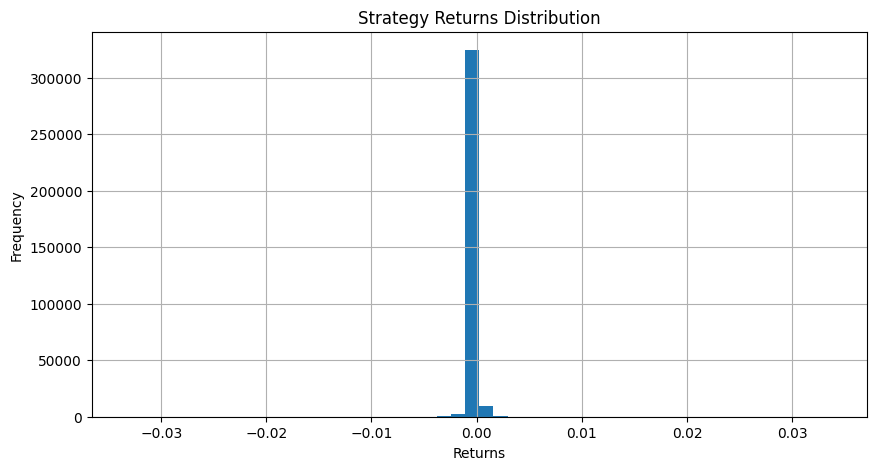

,Strategy,Benchmark
Metric,,
Total Return,58.39%,49.58%
Annualized Return,84.60%,71.04%
Number of Transactions,544,N/A
Average Gain/Loss per Transaction,"$10,752.53",N/A
Maximum Drawdown,-9.84%,-32.50%
Annualized Sharpe Ratio,3.23,1.48
Tracking Error,46.04%,N/A
Information Ratio,-0.03,N/A
Treynor Ratio,3.76,N/A


In [99]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': True,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### Contribution to Return Attribution Model - BTC Direction

In [135]:
bench_df = trading_df.loc['2024-01-01':,'BTC_Close'].copy().to_frame()
bench_df['BTC Return'] = bench_df['BTC_Close'].pct_change()
bench_df.head()

,BTC_Close,BTC Return
timestamp,,
2024-01-01 00:00:00+00:00,42260.3,NaN
2024-01-01 00:01:00+00:00,42299.9,0.000937
2024-01-01 00:02:00+00:00,42300.0,0.000002
2024-01-01 00:03:00+00:00,42334.9,0.000825
2024-01-01 00:04:00+00:00,42384.4,0.001169


In [154]:
trade_history

,Date,Action,Asset,Order Type,Execution Price,Quantity,Transaction Fee,Holdings,Portfolio Value
0,2024-01-01 09:07:00+00:00,limit_buy_btc,BTC,buy,42548.3,235.027016,0.0,"{'BTC': 235.02701635553007, 'ETH': 0.0, 'USD':...",1.000000e+07
1,2024-01-01 10:20:00+00:00,limit_sell_btc,BTC,sell,42650.0,235.027016,0.0,"{'BTC': 0.0, 'ETH': 0.0, 'USD': 10023902.24756...",1.002390e+07
2,2024-01-03 06:19:00+00:00,limit_buy_btc,BTC,buy,45277.3,221.389134,0.0,"{'BTC': 221.38913423643538, 'ETH': 0.0, 'USD':...",1.002390e+07
3,2024-01-03 07:01:00+00:00,limit_sell_btc,BTC,sell,45329.2,221.389134,0.0,"{'BTC': 0.0, 'ETH': 0.0, 'USD': 10035392.34363...",1.003539e+07
4,2024-01-03 12:15:00+00:00,limit_buy_btc,BTC,buy,42289.6,237.301661,0.0,"{'BTC': 237.3016614872268, 'ETH': 0.0, 'USD': ...",1.003539e+07
...,...,...,...,...,...,...,...,...,...
539,2024-09-28 19:44:00+00:00,limit_sell_btc,BTC,sell,65730.3,240.709353,0.0,"{'BTC': 0.0, 'ETH': 0.0, 'USD': 15821898.01105...",1.582190e+07
540,2024-09-29 16:47:00+00:00,limit_buy_btc,BTC,buy,65747.6,240.646016,0.0,"{'BTC': 240.64601614442128, 'ETH': 0.0, 'USD':...",1.582190e+07
541,2024-09-29 17:49:00+00:00,limit_sell_btc,BTC,sell,65841.1,240.646016,0.0,"{'BTC': 0.0, 'ETH': 0.0, 'USD': 15844398.41356...",1.584440e+07
542,2024-09-29 19:31:00+00:00,limit_buy_btc,BTC,buy,65875.5,240.520351,0.0,"{'BTC': 240.52035147462192, 'ETH': 0.0, 'USD':...",1.584440e+07


In [203]:
trade_df = trade_history.loc[trade_history['Order Type']=='buy'][['Date','Portfolio Value','Quantity']].copy()
trade_df['Portfolio Return'] = trade_df['Portfolio Value'].pct_change()
trade_df = trade_df.set_index('Date')
trade_df['Portfolio Holdings']  = trade_df['Quantity']
trade_df.drop(['Quantity'], axis=1, inplace=True)

ctr_df = bench_df.merge(trade_df, left_index=True, right_index=True, how='left')

ctr_df['BTC Return'].iloc[0] = 0
ctr_df['Portfolio Return'].iloc[0] = 0

ctr_df.dropna(subset=['Portfolio Value'],inplace=True)

ctr_df['BTC Return'].iloc[0] = 0
ctr_df['Portfolio Return'].iloc[0] = 0

ctr_df['BTC Holdings'] = 1e7 / ctr_df['BTC_Close'].iloc[0]

ctr_df['allocation_effect'] = (ctr_df['Portfolio Holdings'] - ctr_df['BTC Holdings']) * ctr_df['BTC Return']
ctr_df['selection_effect'] = ctr_df['Portfolio Holdings'] * (ctr_df['Portfolio Return'] - ctr_df['BTC Return'])
ctr_df['interaction_effect'] = (ctr_df['Portfolio Holdings'] - ctr_df['BTC Holdings']) * (ctr_df['Portfolio Return'] - ctr_df['BTC Return'])
ctr_df['total_effect'] = ctr_df['allocation_effect'] + ctr_df['selection_effect'] + ctr_df['interaction_effect']

ctr_df['cumulative_allocation_effect'] = ctr_df['allocation_effect'].cumsum()
ctr_df['cumulative_selection_effect'] = ctr_df['selection_effect'].cumsum()
ctr_df['cumulative_interaction_effect'] = ctr_df['interaction_effect'].cumsum()
ctr_df['cumulative_total_effect'] = ctr_df['total_effect'].cumsum()

ctr_window = 10
ctr_df['rolling_allocation_effect'] = ctr_df['allocation_effect'].rolling(window=ctr_window).mean()
ctr_df['rolling_selection_effect'] = ctr_df['selection_effect'].rolling(window=ctr_window).mean()
ctr_df['rolling_interaction_effect'] = ctr_df['interaction_effect'].rolling(window=ctr_window).mean()
ctr_df['rolling_total_effect'] = ctr_df['total_effect'].rolling(window=ctr_window).mean()

ctr_df

,BTC_Close,BTC Return,Portfolio Value,Portfolio Return,Portfolio Holdings,BTC Holdings,allocation_effect,selection_effect,interaction_effect,total_effect,cumulative_allocation_effect,cumulative_selection_effect,cumulative_interaction_effect,cumulative_total_effect,rolling_allocation_effect,rolling_selection_effect,rolling_interaction_effect,rolling_total_effect
timestamp,,,,,,,,,,,,,,,,,,
2024-01-01 09:07:00+00:00,42548.3,0.000000,1.000000e+07,0.000000,235.027016,235.027016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2024-01-03 06:19:00+00:00,45277.3,0.000944,1.002390e+07,0.002390,221.389134,235.027016,-0.012874,0.320186,-0.019724,0.287588,-0.012874,0.320186,-0.019724,0.287588,NaN,NaN,NaN,NaN
2024-01-03 12:15:00+00:00,42253.9,0.009138,1.003539e+07,0.001146,237.301661,235.027016,0.020785,-1.896338,-0.018177,-1.893731,0.007911,-1.576152,-0.037901,-1.606143,NaN,NaN,NaN,NaN
2024-01-06 03:20:00+00:00,43955.6,-0.000182,1.023957e+07,0.020345,232.912224,235.027016,0.000385,4.781082,-0.043411,4.738055,0.008296,3.204929,-0.081312,3.131913,NaN,NaN,NaN,NaN
2024-01-07 08:02:00+00:00,44148.4,0.000823,1.023652e+07,-0.000298,231.850830,235.027016,-0.002614,-0.259877,0.003560,-0.258931,0.005682,2.945052,-0.077752,2.872982,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20 10:41:00+00:00,63605.0,0.000960,1.578087e+07,-0.000063,248.106981,235.027016,0.012556,-0.253884,-0.013385,-0.254712,-0.513254,86.392634,-2.111497,83.767883,0.016649,0.760862,0.109565,0.887076
2024-09-21 22:36:00+00:00,63161.8,0.000152,1.576918e+07,-0.000741,249.662906,235.027016,0.002225,-0.222829,-0.013063,-0.233667,-0.511029,86.169805,-2.124560,83.534216,0.008685,0.599430,0.085079,0.693194
2024-09-28 17:16:00+00:00,65608.8,0.000221,1.579265e+07,0.001488,240.709353,235.027016,0.001256,0.305023,0.007201,0.313480,-0.509773,86.474828,-2.117359,83.847695,0.008811,0.720991,0.100772,0.830574


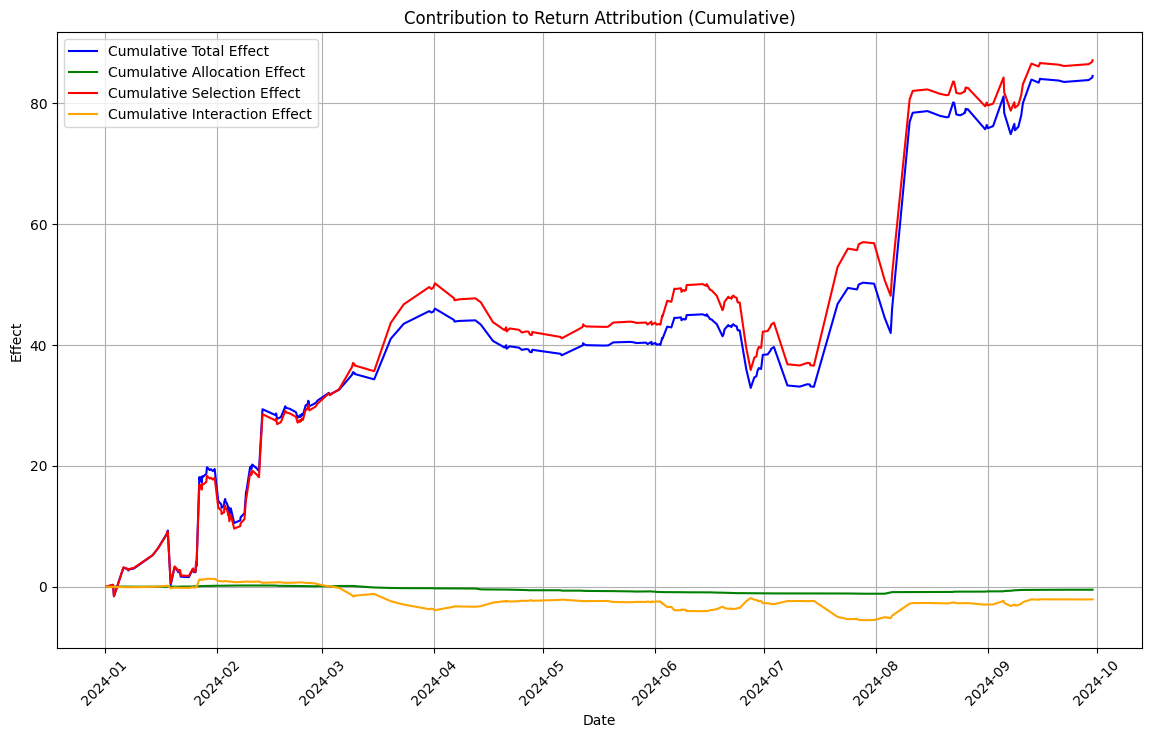

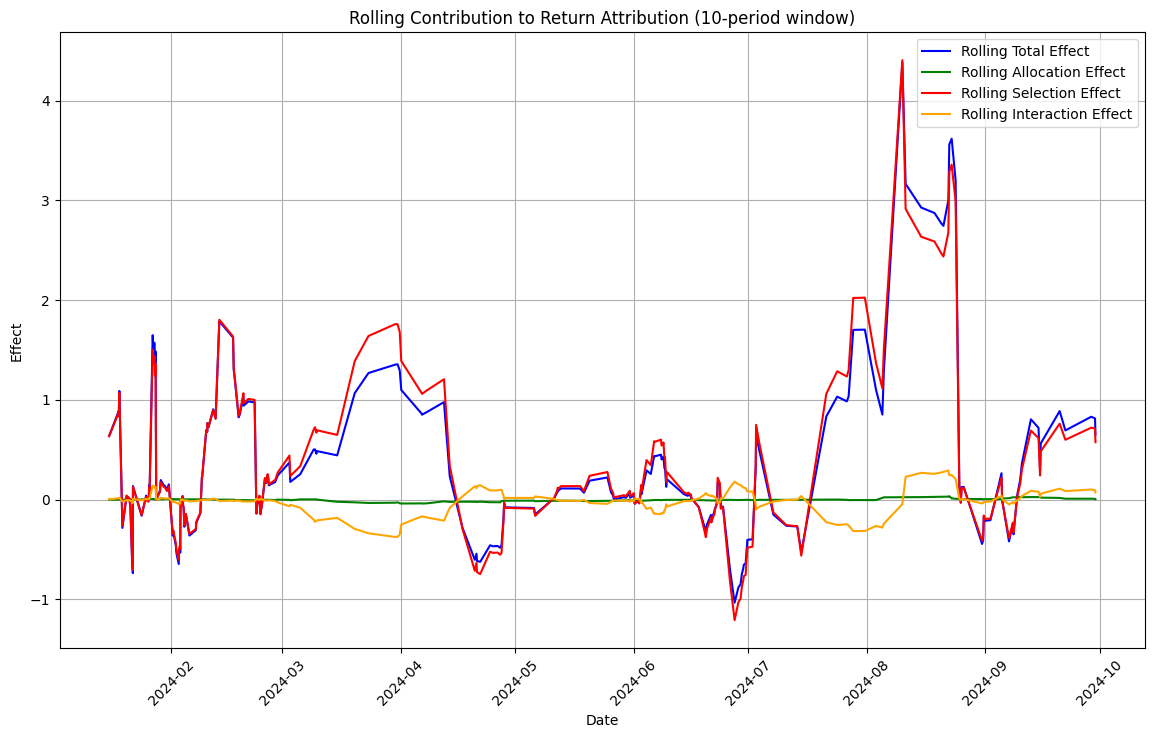

In [ ]:
# cumulative plot
df = ctr_df.copy()
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['cumulative_total_effect'], label='Cumulative Total Effect', color='blue')
plt.plot(df.index, df['cumulative_allocation_effect'], label='Cumulative Allocation Effect', color='green')
plt.plot(df.index, df['cumulative_selection_effect'], label='Cumulative Selection Effect', color='red')
plt.plot(df.index, df['cumulative_interaction_effect'], label='Cumulative Interaction Effect', color='orange')

plt.xlabel('Date')
plt.ylabel('Effect')
plt.title('Contribution to Return Attribution (Cumulative)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# rolling average plot
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['rolling_total_effect'], label='Rolling Total Effect', color='blue')
plt.plot(df.index, df['rolling_allocation_effect'], label='Rolling Allocation Effect', color='green')
plt.plot(df.index, df['rolling_selection_effect'], label='Rolling Selection Effect', color='red')
plt.plot(df.index, df['rolling_interaction_effect'], label='Rolling Interaction Effect', color='orange')

plt.xlabel('Date')
plt.ylabel('Effect')
plt.title(f'Rolling Contribution to Return Attribution ({ctr_window}-period window)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Axes: >

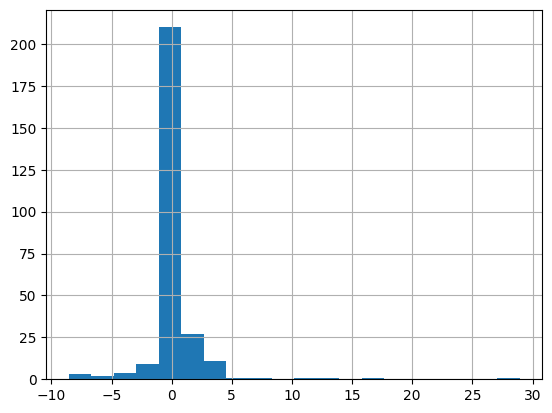

In [166]:
ctr_df['selection_effect'].hist(bins=20)

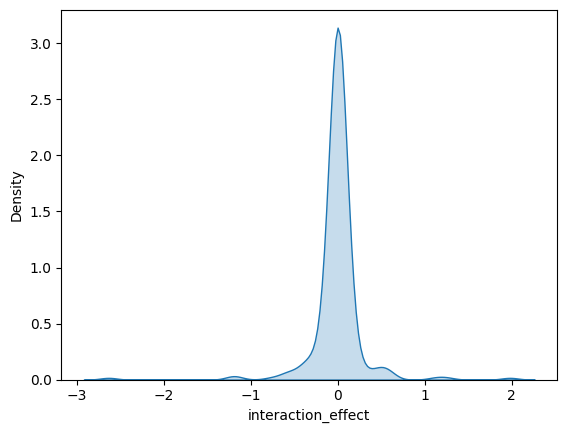

In [183]:
import seaborn as sns

sns.kdeplot(ctr_df['interaction_effect'], fill=True)
plt.show()

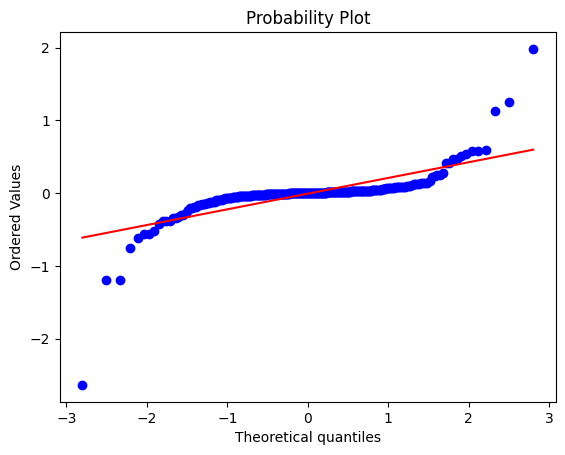

In [178]:
import scipy.stats as stats

stats.probplot(ctr_df['interaction_effect'], dist="norm", plot=plt)
plt.show()

### ETH Future Direction Full Sample

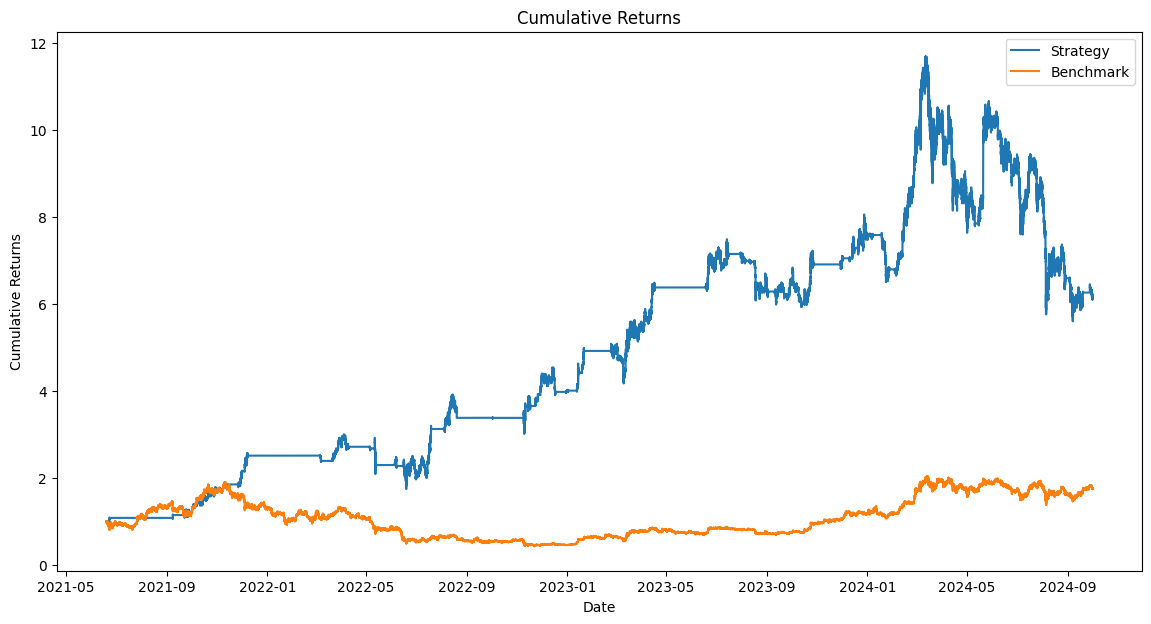

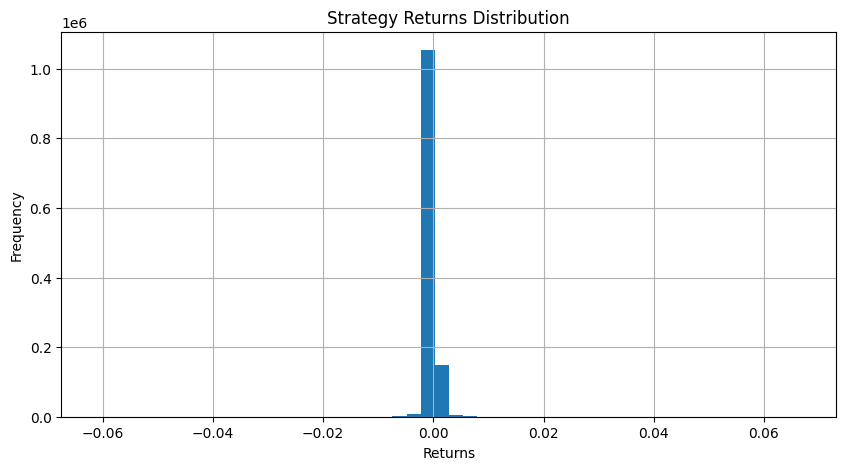

,Strategy,Benchmark
Metric,,
Total Return,513.66%,74.70%
Annualized Return,73.69%,18.50%
Number of Transactions,119,N/A
Average Gain/Loss per Transaction,"$446,234.02",N/A
Maximum Drawdown,-52.11%,-77.49%
Annualized Sharpe Ratio,1.78,0.70
Tracking Error,61.90%,N/A
Information Ratio,0.76,N/A
Treynor Ratio,2.57,N/A


In [30]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': True,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df,
    target_variable='ETH_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### ETH Future Direction OOS Only

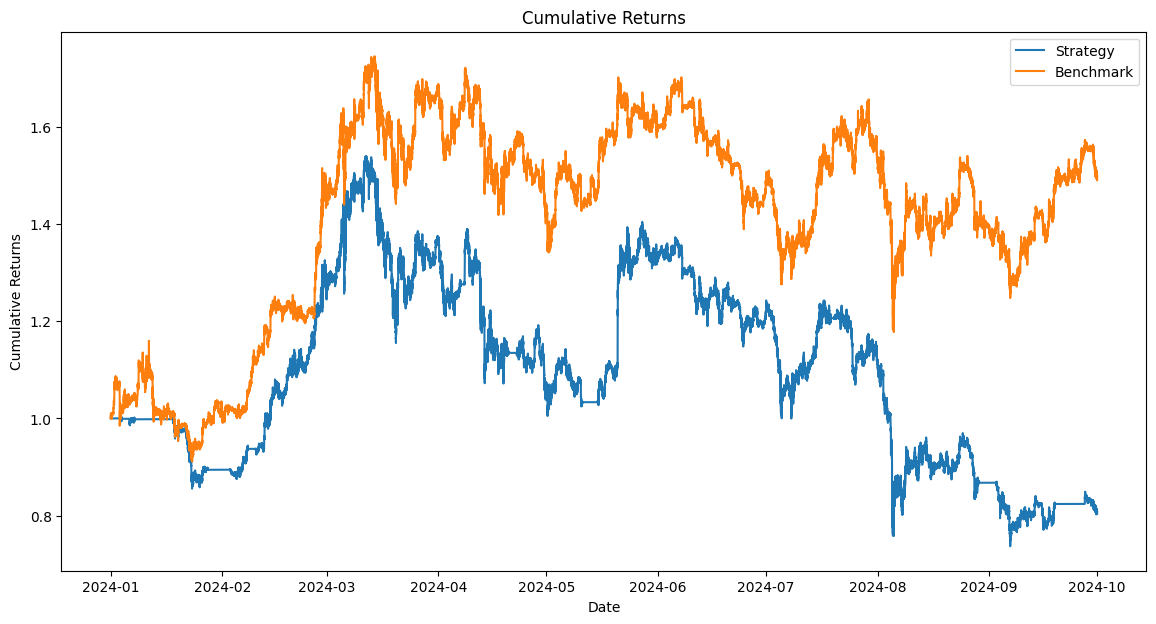

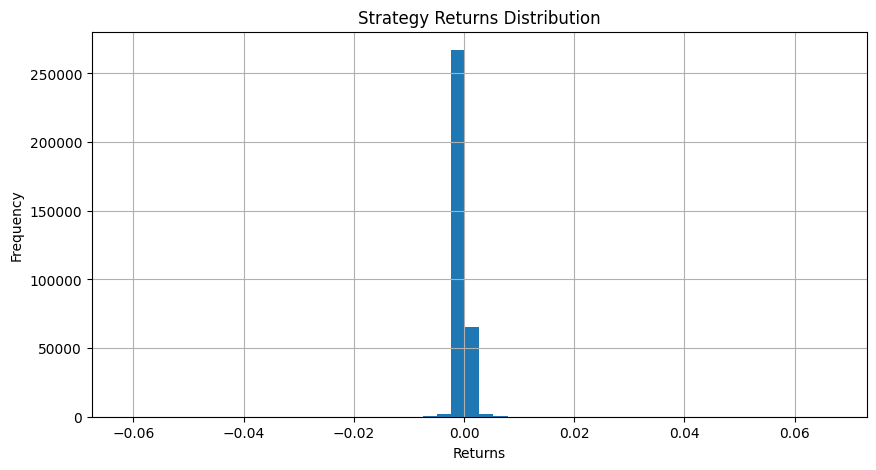

,Strategy,Benchmark
Metric,,
Total Return,-19.19%,49.58%
Annualized Return,-24.72%,71.04%
Number of Transactions,29,N/A
Average Gain/Loss per Transaction,"$-62,702.13",N/A
Maximum Drawdown,-52.11%,-32.50%
Annualized Sharpe Ratio,-0.30,1.48
Tracking Error,50.46%,N/A
Information Ratio,-1.85,N/A
Treynor Ratio,-0.28,N/A


In [31]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': True,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='ETH_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### BTC Outperforms ETH Full Sample

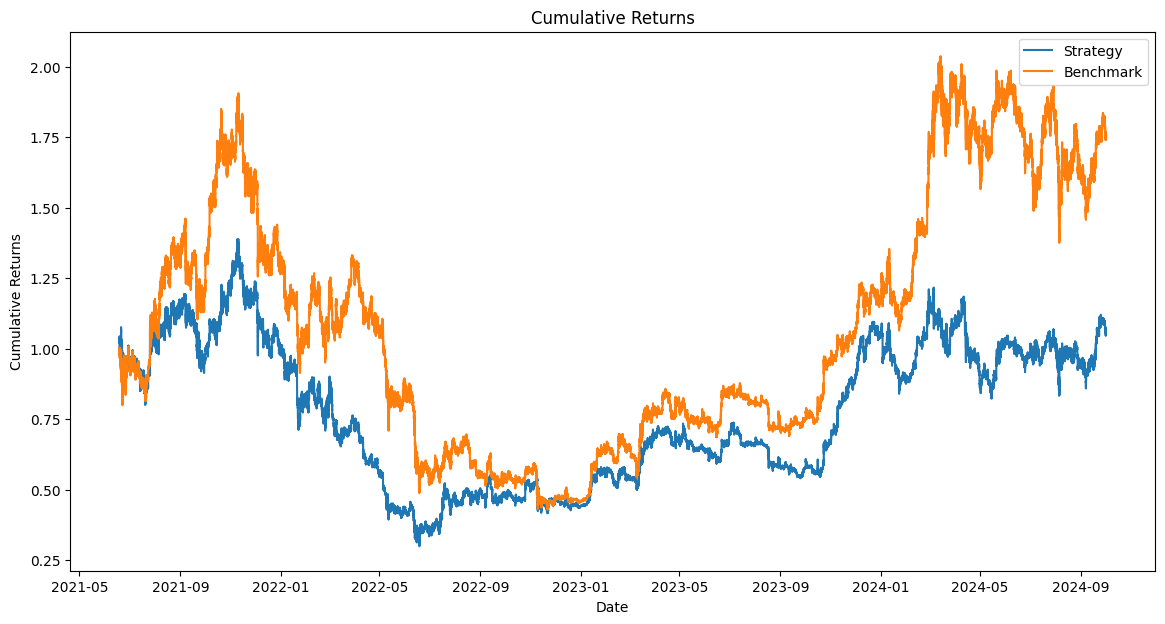

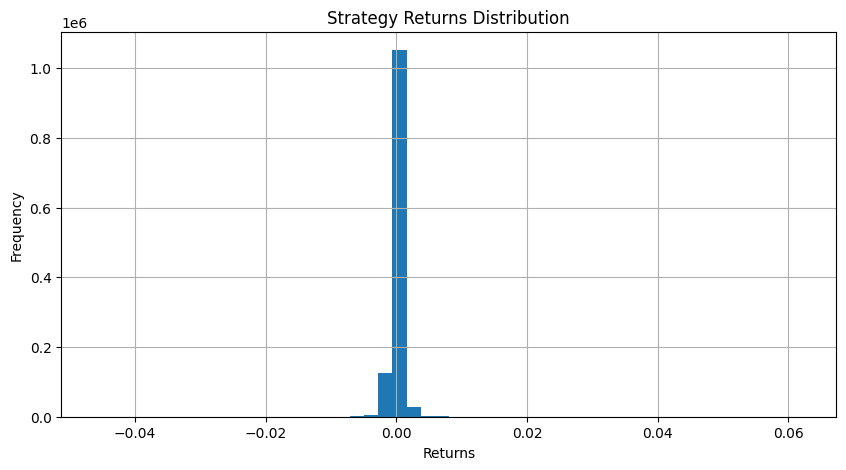

,Strategy,Benchmark
Metric,,
Total Return,5.22%,74.70%
Annualized Return,1.56%,18.50%
Number of Transactions,10800,N/A
Average Gain/Loss per Transaction,$55.04,N/A
Maximum Drawdown,-78.44%,-77.49%
Annualized Sharpe Ratio,0.34,0.70
Tracking Error,48.98%,N/A
Information Ratio,-0.48,N/A
Treynor Ratio,0.32,N/A


In [32]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': True,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df,
    target_variable='BTC_Outperforms_ETH_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### BTC Outperforms ETH OOS Only

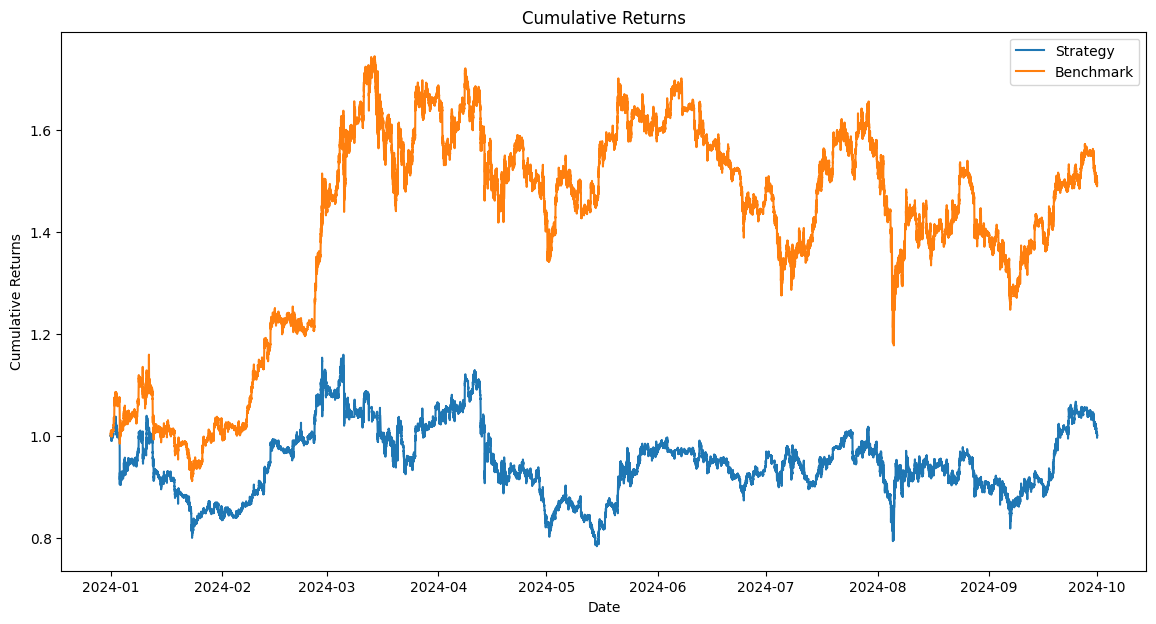

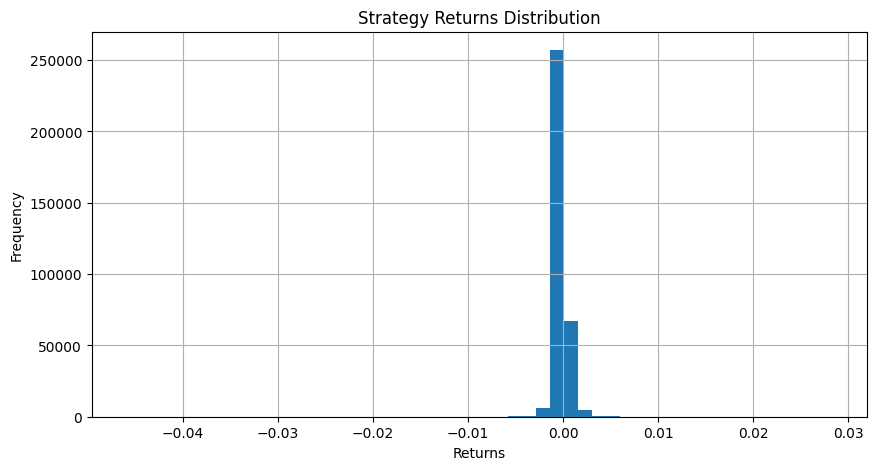

,Strategy,Benchmark
Metric,,
Total Return,0.23%,49.58%
Annualized Return,0.31%,71.04%
Number of Transactions,3063,N/A
Average Gain/Loss per Transaction,$28.36,N/A
Maximum Drawdown,-32.39%,-32.50%
Annualized Sharpe Ratio,0.25,1.48
Tracking Error,43.72%,N/A
Information Ratio,-1.47,N/A
Treynor Ratio,0.21,N/A


In [33]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': True,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='BTC_Outperforms_ETH_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


## Strategy Results for Single Indicator with Market Orders

### BTC Future Direction Full Sample

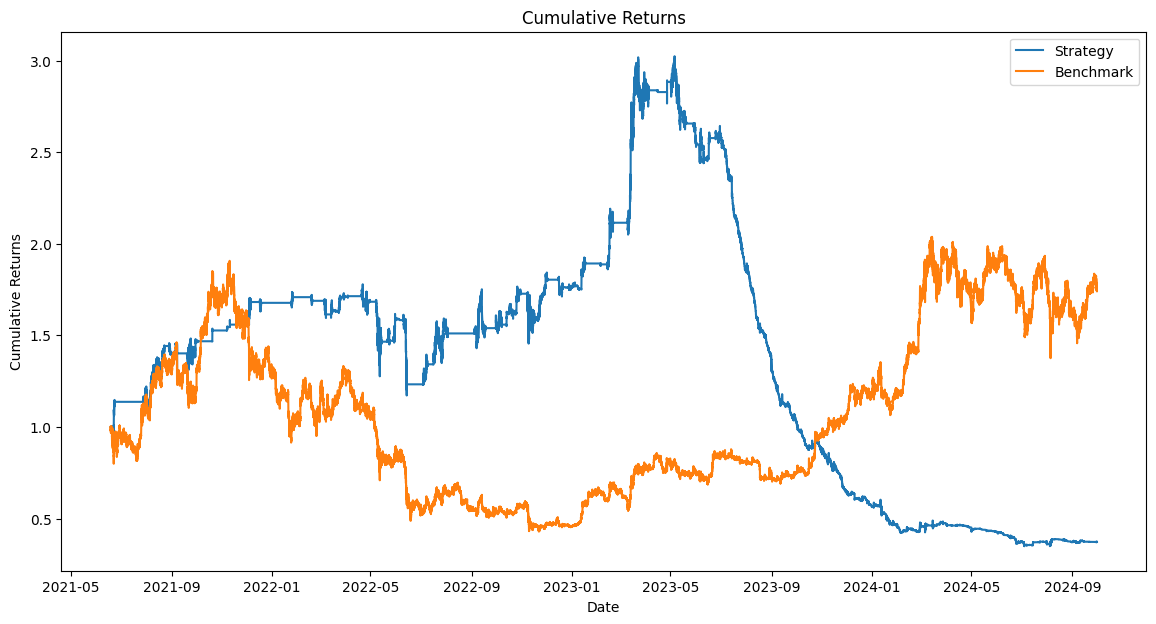

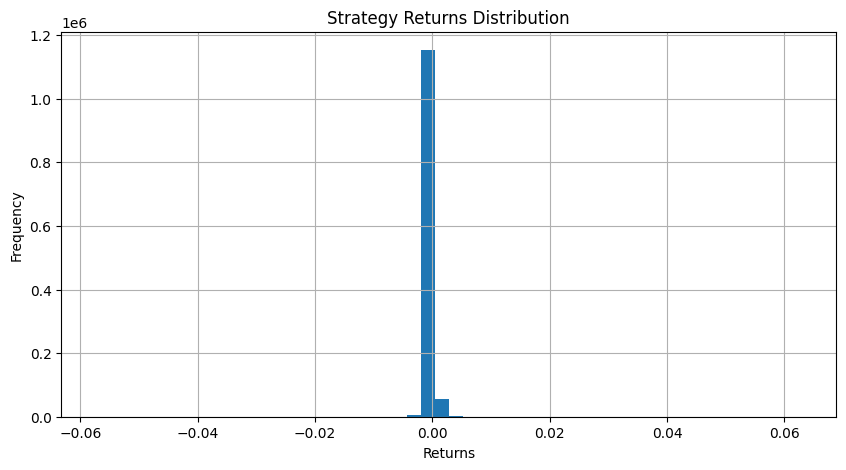

,Strategy,Benchmark
Metric,,
Total Return,-62.54%,74.70%
Annualized Return,-25.83%,18.50%
Number of Transactions,3391,N/A
Average Gain/Loss per Transaction,"$-1,846.58",N/A
Maximum Drawdown,-88.45%,-77.49%
Annualized Sharpe Ratio,-0.95,0.70
Tracking Error,52.37%,N/A
Information Ratio,-1.53,N/A
Treynor Ratio,-1.05,N/A


In [34]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': False,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df,
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### BTC Future Direction OOS Only

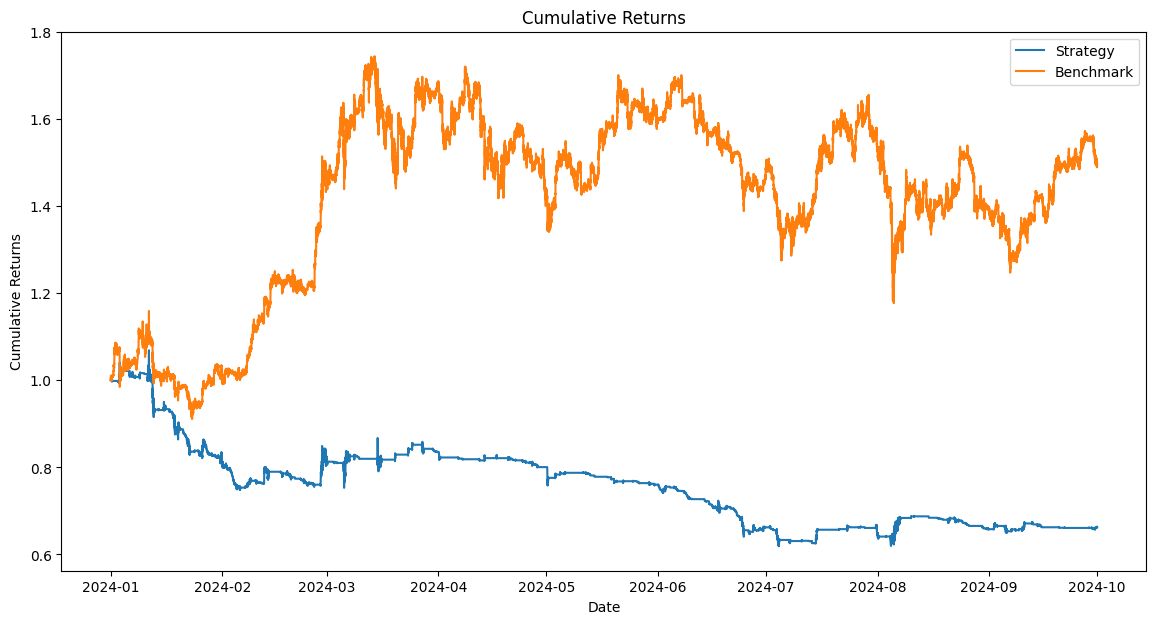

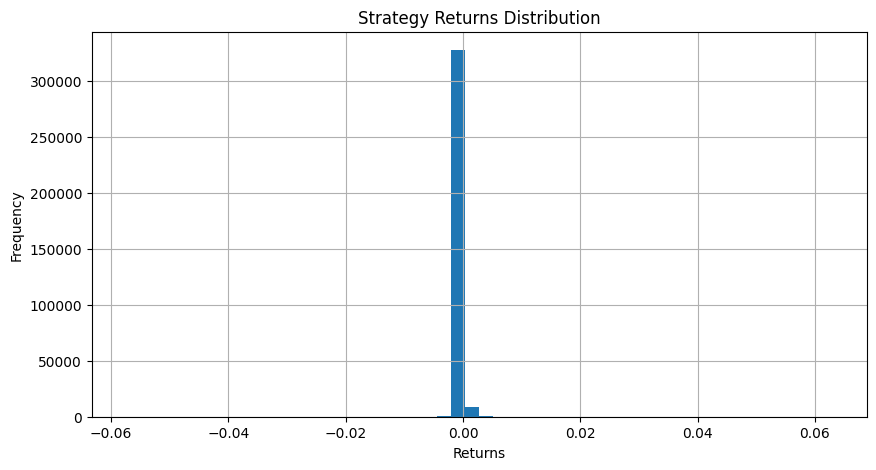

,Strategy,Benchmark
Metric,,
Total Return,-33.62%,49.58%
Annualized Return,-42.09%,71.04%
Number of Transactions,871,N/A
Average Gain/Loss per Transaction,"$-3,884.09",N/A
Maximum Drawdown,-42.10%,-32.50%
Annualized Sharpe Ratio,-2.28,1.48
Tracking Error,44.35%,N/A
Information Ratio,-3.08,N/A
Treynor Ratio,-2.33,N/A


In [35]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': False,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='BTC_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### ETH Future Direction Full Sample

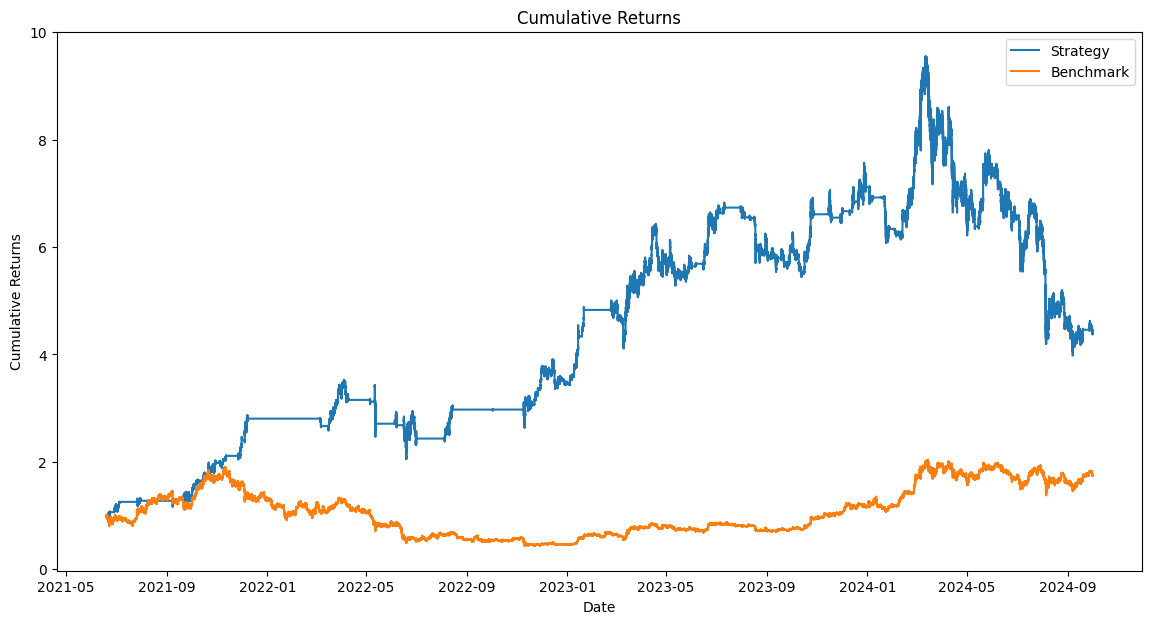

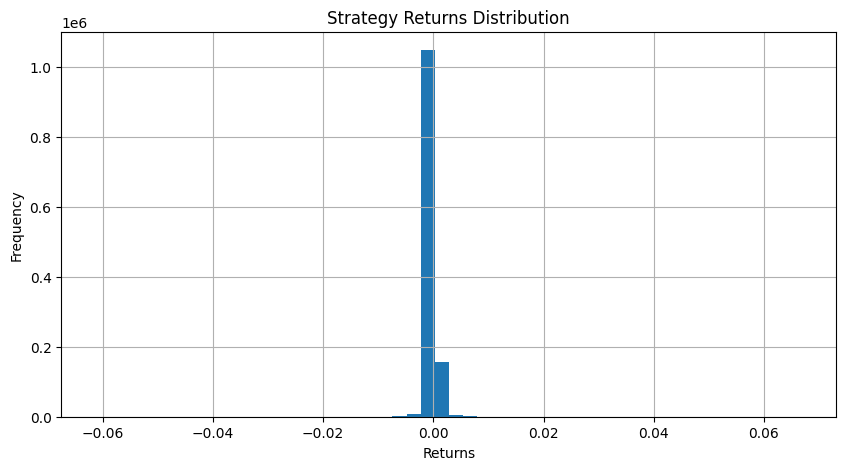

,Strategy,Benchmark
Metric,,
Total Return,340.36%,74.70%
Annualized Return,57.01%,18.50%
Number of Transactions,179,N/A
Average Gain/Loss per Transaction,"$194,225.94",N/A
Maximum Drawdown,-58.35%,-77.49%
Annualized Sharpe Ratio,1.48,0.70
Tracking Error,60.98%,N/A
Information Ratio,0.54,N/A
Treynor Ratio,2.04,N/A


In [36]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': False,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df,
    target_variable='ETH_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### ETH Future Direction OOS Only

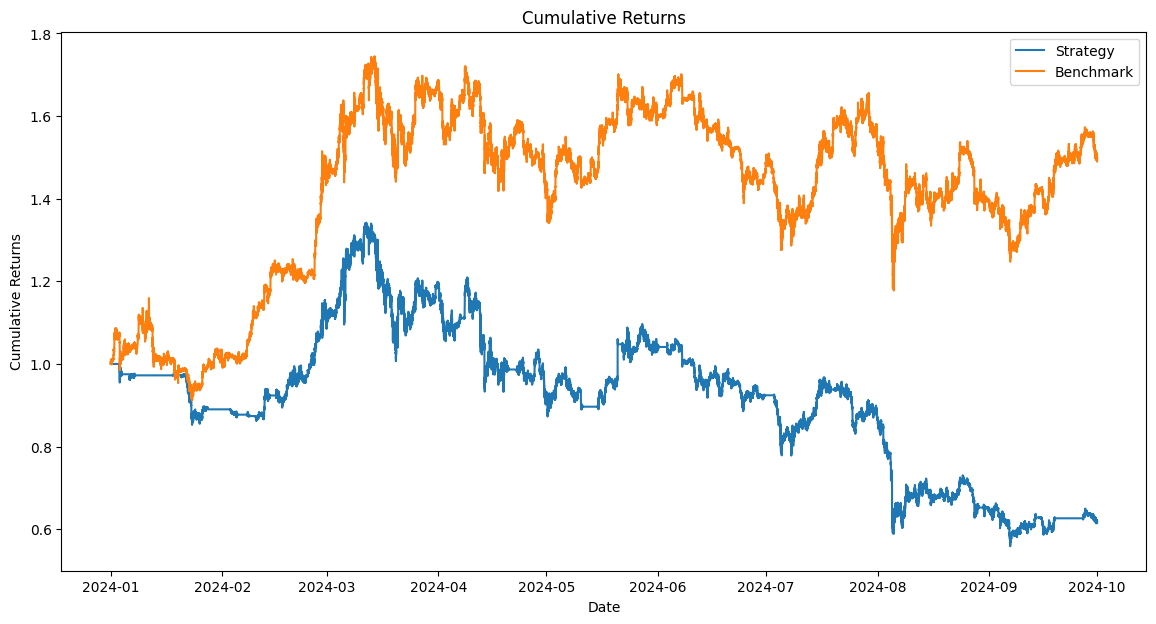

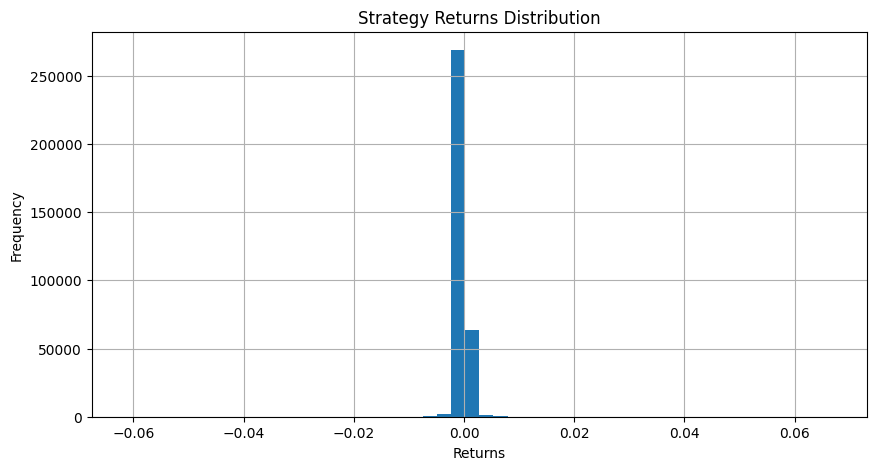

,Strategy,Benchmark
Metric,,
Total Return,-38.15%,49.58%
Annualized Return,-47.30%,71.04%
Number of Transactions,49,N/A
Average Gain/Loss per Transaction,"$-77,737.93",N/A
Maximum Drawdown,-58.35%,-32.50%
Annualized Sharpe Ratio,-1.06,1.48
Tracking Error,50.22%,N/A
Information Ratio,-2.69,N/A
Treynor Ratio,-0.96,N/A


In [37]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': False,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='ETH_Future_Direction_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### BTC Outperforms ETH Full Sample

In [38]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': False,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df,
    target_variable='BTC_Outperforms_ETH_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


KeyboardInterrupt: 

### BTC Outperforms ETH OOS Only

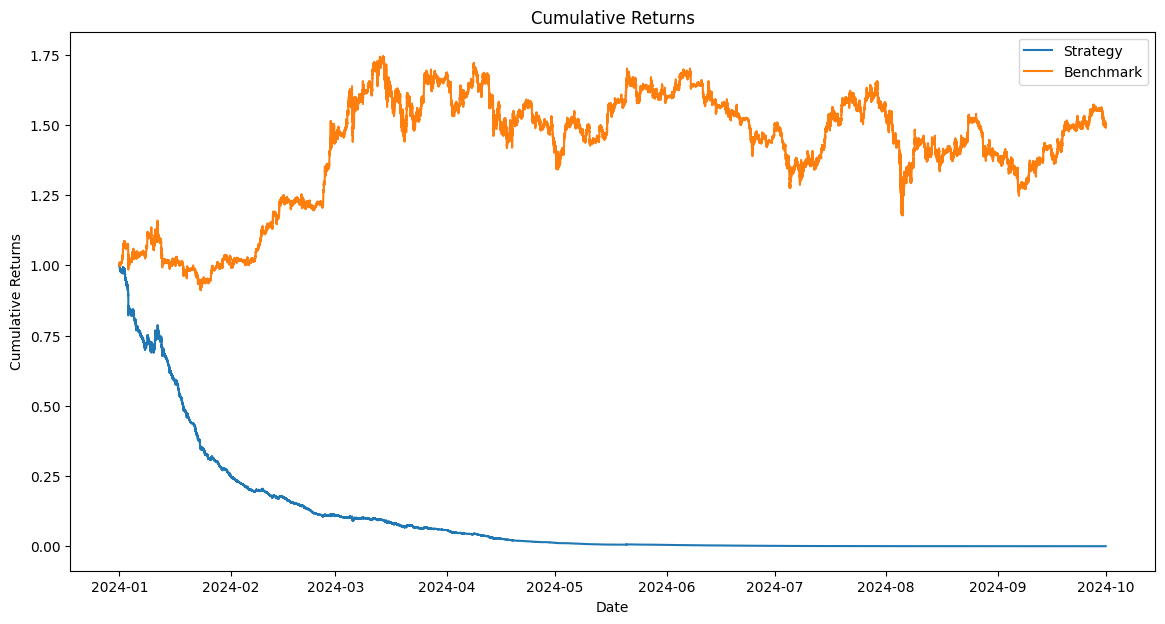

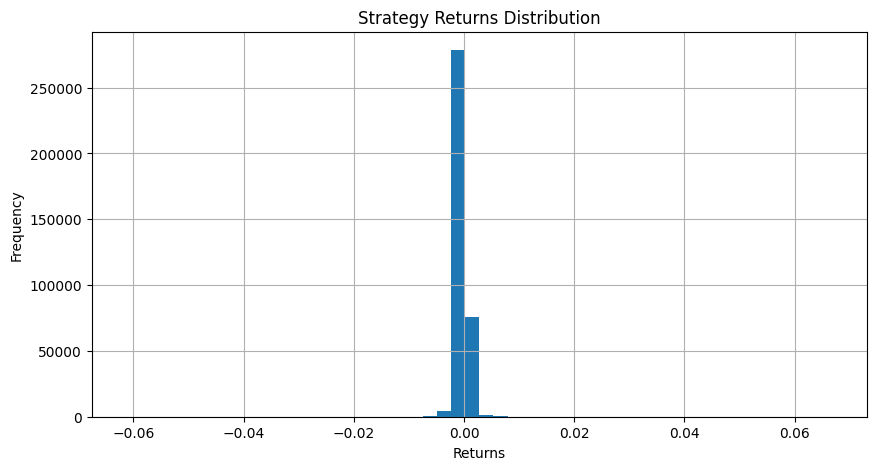

,Strategy,Benchmark
Metric,,
Total Return,-100.00%,49.58%
Annualized Return,-100.00%,71.04%
Number of Transactions,10293,N/A
Average Gain/Loss per Transaction,$-970.65,N/A
Maximum Drawdown,-100.00%,-32.50%
Annualized Sharpe Ratio,-27.34,1.43
Tracking Error,45.39%,N/A
Information Ratio,-37.57,N/A
Treynor Ratio,-20.21,N/A


In [ ]:
strategy_params = {
    'investment_fraction': 1.0,
    'use_limit_orders': False,          # Use limit orders
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'limit_order_buffer': 0.00001,       # 0.1% price buffer
    'limit_order_duration': 3          # 5 minutes duration
}

# Simulate the trading strategy for 'BTC_Future_Direction_5m'
df_with_results, performance_metrics, trade_history = simulate_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    target_variable='BTC_Outperforms_ETH_5m',
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


## Multi-Indicator Strategy

In [ ]:
def simulate_simple_trading_strategy(
    df,
    initial_capital=10_000_000,
    transaction_cost=0.001,  # 0.1% transaction cost
    start_date=None,
    end_date=None,
    strategy_params=None
):
    """
    Simulate a simplified trading strategy holding one asset at a time, including limit order execution.

    Parameters:
    - df: DataFrame containing price data and predictions.
    - initial_capital: Starting capital in USD.
    - transaction_cost: Transaction cost as a proportion (e.g., 0.001 for 0.1%).
    - start_date: Start date for the simulation (string in 'YYYY-MM-DD' format).
    - end_date: End date for the simulation (string in 'YYYY-MM-DD' format).
    - strategy_params: Dictionary containing strategy parameters, including thresholds and execution parameters.

    Returns:
    - df: DataFrame with added columns for positions and portfolio value.
    - performance_metrics: Dictionary of performance metrics.
    - trade_history_df: DataFrame of trade history.
    """
    import pandas as pd

    # Set default strategy parameters if not provided
    if strategy_params is None:
        strategy_params = {
            'buy_threshold': 0.6,
            'sell_threshold': 0.4,
            'use_limit_orders': False,
            'limit_order_buffer': 0.001,
            'limit_order_duration': 5  # in ticks
        }

    # Filter data based on date range
    if start_date is not None and end_date is not None:
        df = df[(df.index >= start_date) & (df.index <= end_date)].copy()
    else:
        df = df.copy()

    # Initialize variables
    capital = initial_capital
    holdings = {'BTC': 0.0, 'ETH': 0.0, 'USD': capital}
    position_history = []
    portfolio_value_history = []
    trade_history = []
    holdings_history = []
    transaction_costs_total = 0.0
    pending_limit_orders = []
    trade_list = []  # 1 if a trade occurs, else 0
    benchmark_position_history = []

    # Initialize benchmark holdings (buy-and-hold BTC)
    btc_benchmark_balance = initial_capital / df.iloc[0]['BTC_High']

    # Iterate over each row in the DataFrame
    for idx in range(len(df)):
        row = df.iloc[idx]
        date = df.index[idx]

        # Get High and Low prices
        btc_high = row['BTC_High']
        btc_low = row['BTC_Low']
        eth_high = row['ETH_High']
        eth_low = row['ETH_Low']

        # Update 'can_execute' flag for pending limit orders
        for order in pending_limit_orders:
            if not order['can_execute']:
                # Allow execution starting from the next tick after the order was placed
                if idx > order['entry_idx']:
                    order['can_execute'] = True

        # Process pending limit orders
        orders_to_remove = []
        trade_occurred = 0  # 1 if a trade occurs
        for order in pending_limit_orders:
            asset = order['asset']
            order_type = order['type']
            limit_price = order['limit_price']
            order_entry_idx = order['entry_idx']
            duration = strategy_params['limit_order_duration']

            # Check if order duration has expired
            if idx - order_entry_idx >= duration:
                orders_to_remove.append(order)
                continue

            # Skip orders that cannot be executed yet
            if not order['can_execute']:
                continue

            # Get price data for the asset
            if asset == 'BTC':
                high_price = btc_high
                low_price = btc_low
            elif asset == 'ETH':
                high_price = eth_high
                low_price = eth_low
            else:
                continue

            # Check if limit price is reached
            if order_type == 'buy' and low_price <= limit_price:
                # Execute buy at limit price
                investment_amount = holdings['USD']
                transaction_fee = investment_amount * transaction_cost
                quantity = (investment_amount - transaction_fee) / limit_price
                holdings['USD'] = 0.0
                holdings[asset] += quantity
                transaction_costs_total += transaction_fee
                trade_history.append({
                    'Date': date,
                    'Action': f'limit_buy_{asset.lower()}',
                    'Asset': asset,
                    'Order Type': 'buy',
                    'Execution Price': limit_price,
                    'Quantity': quantity,
                    'Transaction Fee': transaction_fee,
                    'Holdings': holdings.copy()
                })
                orders_to_remove.append(order)
                trade_occurred = 1
            elif order_type == 'sell' and high_price >= limit_price:
                # Execute sell at limit price
                quantity = holdings[asset]
                proceeds = quantity * limit_price
                transaction_fee = proceeds * transaction_cost
                holdings['USD'] += proceeds - transaction_fee
                holdings[asset] = 0.0
                transaction_costs_total += transaction_fee
                trade_history.append({
                    'Date': date,
                    'Action': f'limit_sell_{asset.lower()}',
                    'Asset': asset,
                    'Order Type': 'sell',
                    'Execution Price': limit_price,
                    'Quantity': quantity,
                    'Transaction Fee': transaction_fee,
                    'Holdings': holdings.copy()
                })
                orders_to_remove.append(order)
                trade_occurred = 1

        # Remove executed or expired orders
        for order in orders_to_remove:
            pending_limit_orders.remove(order)

        # Skip placing new orders if we have pending limit orders
        if len(pending_limit_orders) > 0:
            # Update holdings and portfolio value
            current_btc_price = row['BTC_High']
            current_eth_price = row['ETH_High']
            total_value = holdings['BTC'] * current_btc_price + holdings['ETH'] * current_eth_price + holdings['USD']
            holdings_history.append(holdings.copy())
            portfolio_value_history.append(total_value)
            position_history.append('Pending Order')
            trade_list.append(trade_occurred)
            # Update benchmark position
            benchmark_position = btc_benchmark_balance * current_btc_price
            benchmark_position_history.append(benchmark_position)
            continue

        # Get predictions and probabilities
        signals = {}
        for signal_name in ['BTC_Future_Direction_5m', 'ETH_Future_Direction_5m', 'BTC_Outperforms_ETH_5m']:
            prediction = row[signal_name]
            proba_column = f'{signal_name}_Proba'
            if proba_column in df.columns:
                prediction_proba = row[proba_column]
            else:
                prediction_proba = 1.0 if prediction == 1 else 0.0
            signals[signal_name] = {'prediction': prediction, 'proba': prediction_proba}

        # Determine actions based on thresholds
        buy_threshold = strategy_params['buy_threshold']
        sell_threshold = strategy_params['sell_threshold']

        actions = {}
        for signal_name, signal_info in signals.items():
            if signal_info['proba'] >= buy_threshold:
                actions[signal_name] = 'buy'
            elif signal_info['proba'] <= sell_threshold:
                actions[signal_name] = 'sell'
            else:
                actions[signal_name] = 'hold'

        # Decide whether to trade
        current_asset = 'USD'
        if holdings['BTC'] > 0:
            current_asset = 'BTC'
        elif holdings['ETH'] > 0:
            current_asset = 'ETH'

        desired_asset = current_asset  # Default to holding current asset

        # Logic when holding USD
        if current_asset == 'USD':
            btc_action = actions['BTC_Future_Direction_5m']
            eth_action = actions['ETH_Future_Direction_5m']
            btc_proba = signals['BTC_Future_Direction_5m']['proba']
            eth_proba = signals['ETH_Future_Direction_5m']['proba']
            btc_eth_action = actions['BTC_Outperforms_ETH_5m']

            if btc_action == 'buy' and eth_action != 'buy':
                desired_asset = 'BTC'
            elif eth_action == 'buy' and btc_action != 'buy':
                desired_asset = 'ETH'
            elif btc_action == 'buy' and eth_action == 'buy':
                # Use BTC_Outperforms_ETH_5m to decide
                if btc_eth_action == 'buy':
                    desired_asset = 'BTC'
                elif btc_eth_action == 'sell':
                    desired_asset = 'ETH'
                else:
                    # Choose the asset with higher probability
                    if btc_proba > eth_proba:
                        desired_asset = 'BTC'
                    else:
                        desired_asset = 'ETH'
            else:
                desired_asset = 'USD'  # No buy signals, stay in USD

        # Logic when holding an asset
        else:
            asset_action = actions[f'{current_asset}_Future_Direction_5m']
            if asset_action == 'sell':
                desired_asset = 'USD'  # Sell the asset
            else:
                desired_asset = current_asset  # Keep holding the asset

        # Execute trades if desired asset has changed
        if desired_asset != current_asset:
            # Sell current asset if not USD
            if current_asset != 'USD':
                if strategy_params['use_limit_orders']:
                    # Place limit sell order above current High price
                    limit_price = (btc_high if current_asset == 'BTC' else eth_high) * (1 + strategy_params['limit_order_buffer'])
                    pending_limit_orders.append({
                        'asset': current_asset,
                        'type': 'sell',
                        'limit_price': limit_price,
                        'entry_idx': idx,
                        'can_execute': False  # Will be set to True starting from next tick
                    })
                else:
                    # Execute sell at next tick's Low price
                    if idx + 1 < len(df):
                        next_row = df.iloc[idx + 1]
                        execution_price = next_row[f'{current_asset}_Low']
                        quantity = holdings[current_asset]
                        proceeds = quantity * execution_price
                        transaction_fee = proceeds * transaction_cost
                        holdings['USD'] += proceeds - transaction_fee
                        holdings[current_asset] = 0.0
                        transaction_costs_total += transaction_fee
                        trade_history.append({
                            'Date': df.index[idx + 1],
                            'Action': f'sell_{current_asset.lower()}',
                            'Asset': current_asset,
                            'Order Type': 'sell',
                            'Execution Price': execution_price,
                            'Quantity': quantity,
                            'Transaction Fee': transaction_fee,
                            'Holdings': holdings.copy()
                        })
                        trade_occurred = 1

            # Buy desired asset if not USD
            if desired_asset != 'USD':
                if strategy_params['use_limit_orders']:
                    # Place limit buy order below current Low price
                    limit_price = (btc_low if desired_asset == 'BTC' else eth_low) * (1 - strategy_params['limit_order_buffer'])
                    pending_limit_orders.append({
                        'asset': desired_asset,
                        'type': 'buy',
                        'limit_price': limit_price,
                        'entry_idx': idx,
                        'can_execute': False  # Will be set to True starting from next tick
                    })
                else:
                    # Execute buy at next tick's High price
                    if idx + 1 < len(df):
                        next_row = df.iloc[idx + 1]
                        execution_price = next_row[f'{desired_asset}_High']
                        investment_amount = holdings['USD']
                        transaction_fee = investment_amount * transaction_cost
                        quantity = (investment_amount - transaction_fee) / execution_price
                        holdings['USD'] = 0.0
                        holdings[desired_asset] = quantity
                        transaction_costs_total += transaction_fee
                        trade_history.append({
                            'Date': df.index[idx + 1],
                            'Action': f'buy_{desired_asset.lower()}',
                            'Asset': desired_asset,
                            'Order Type': 'buy',
                            'Execution Price': execution_price,
                            'Quantity': quantity,
                            'Transaction Fee': transaction_fee,
                            'Holdings': holdings.copy()
                        })
                        trade_occurred = 1

        # Update holdings and portfolio value
        current_btc_price = row['BTC_High']
        current_eth_price = row['ETH_High']
        total_value = holdings['BTC'] * current_btc_price + holdings['ETH'] * current_eth_price + holdings['USD']
        holdings_history.append(holdings.copy())
        portfolio_value_history.append(total_value)
        position_history.append(current_asset)
        trade_list.append(trade_occurred)

        # Update benchmark position
        benchmark_position = btc_benchmark_balance * current_btc_price
        benchmark_position_history.append(benchmark_position)

    # Add the new columns to the DataFrame
    df['Trade Action'] = position_history
    df['Portfolio Value'] = portfolio_value_history
    df['Position'] = portfolio_value_history
    df['Trade'] = trade_list
    df['Pos_Benchmark'] = benchmark_position_history

    # Prepare performance metrics
    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': portfolio_value_history[-1],
        'Total Return (%)': ((portfolio_value_history[-1] / initial_capital) - 1) * 100,
        'Total Transaction Costs': transaction_costs_total,
        'Number of Trades': sum(trade_list)
    }

    # Convert trade history to DataFrame
    trade_history_df = pd.DataFrame(trade_history)

    # Return the DataFrame and performance metrics
    return df, performance_metrics, trade_history_df


## Strategy Results for Multi-Indicator with Limit Orders

### Full Sample

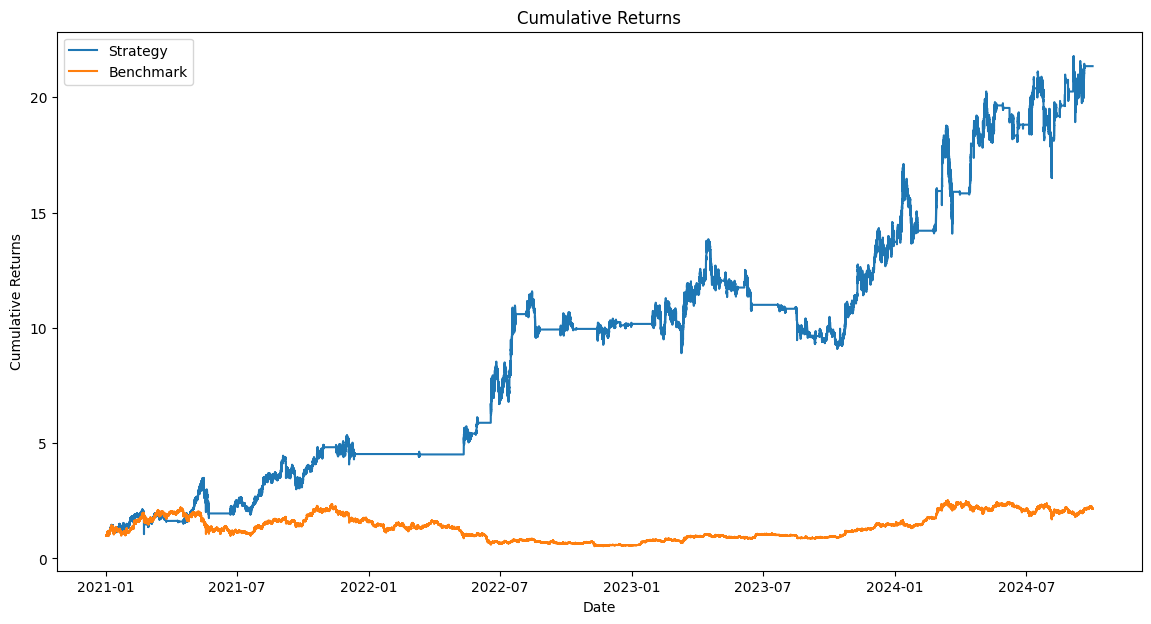

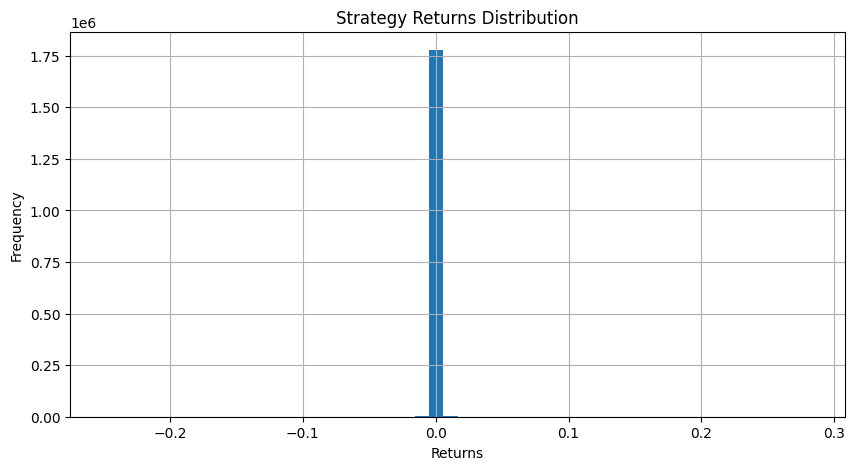

,Strategy,Benchmark
Metric,,
Total Return,2035.34%,115.30%
Annualized Return,126.33%,22.71%
Number of Transactions,114,N/A
Average Gain/Loss per Transaction,"$1,801,224.51",N/A
Maximum Drawdown,-50.43%,-77.49%
Annualized Sharpe Ratio,1.66,0.67
Tracking Error,65.85%,N/A
Information Ratio,1.07,N/A
Treynor Ratio,2.11,N/A


In [ ]:
# Assuming 'df_required' is your DataFrame with the necessary columns

# Define strategy parameters
strategy_params = {
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'use_limit_orders': True,  # Set to True to use limit orders
    'limit_order_buffer': 0.001,
    'limit_order_duration': 5  # Number of ticks limit orders remain active
}

# Simulate the strategy
df_with_results, performance_metrics, trade_history = simulate_simple_trading_strategy(
    df=trading_df,
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### OOS Only

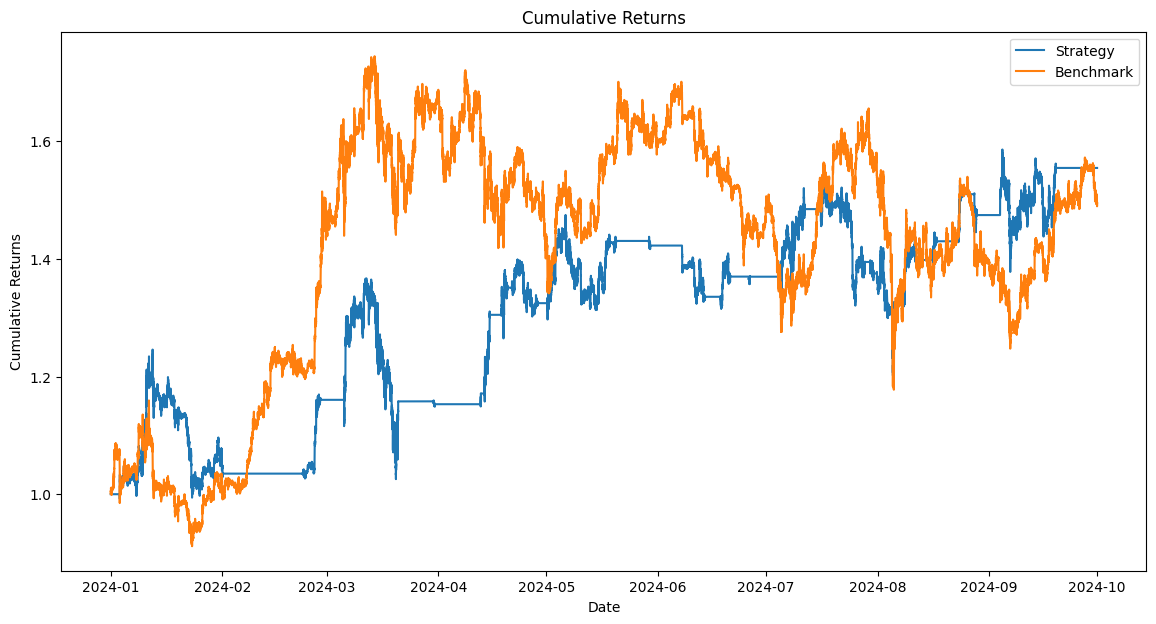

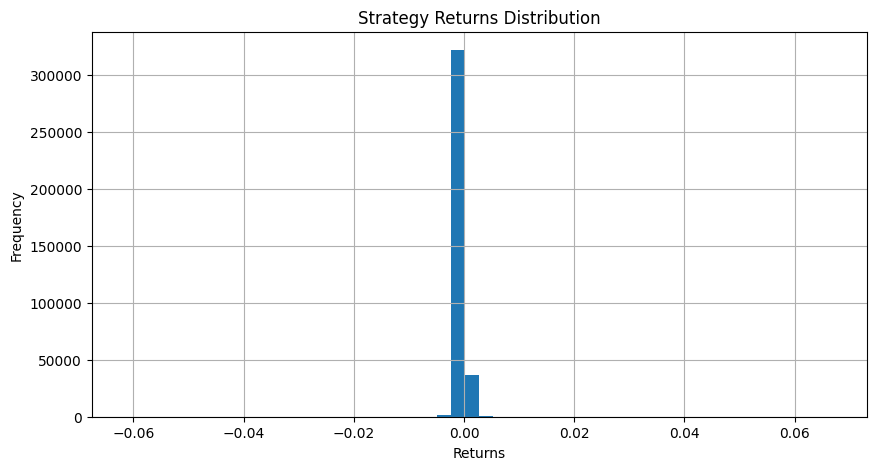

,Strategy,Benchmark
Metric,,
Total Return,55.48%,49.58%
Annualized Return,80.10%,71.04%
Number of Transactions,54,N/A
Average Gain/Loss per Transaction,"$102,374.88",N/A
Maximum Drawdown,-24.98%,-32.50%
Annualized Sharpe Ratio,1.76,1.43
Tracking Error,46.67%,N/A
Information Ratio,0.04,N/A
Treynor Ratio,1.80,N/A


In [ ]:
# Assuming 'df_required' is your DataFrame with the necessary columns

# Define strategy parameters
strategy_params = {
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'use_limit_orders': True,  # Set to True to use limit orders
    'limit_order_buffer': 0.001,
    'limit_order_duration': 5  # Number of ticks limit orders remain active
}

# Simulate the strategy
df_with_results, performance_metrics, trade_history = simulate_simple_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


## Strategy Results for Multi-Indicator with Market Orders

### Full Sample

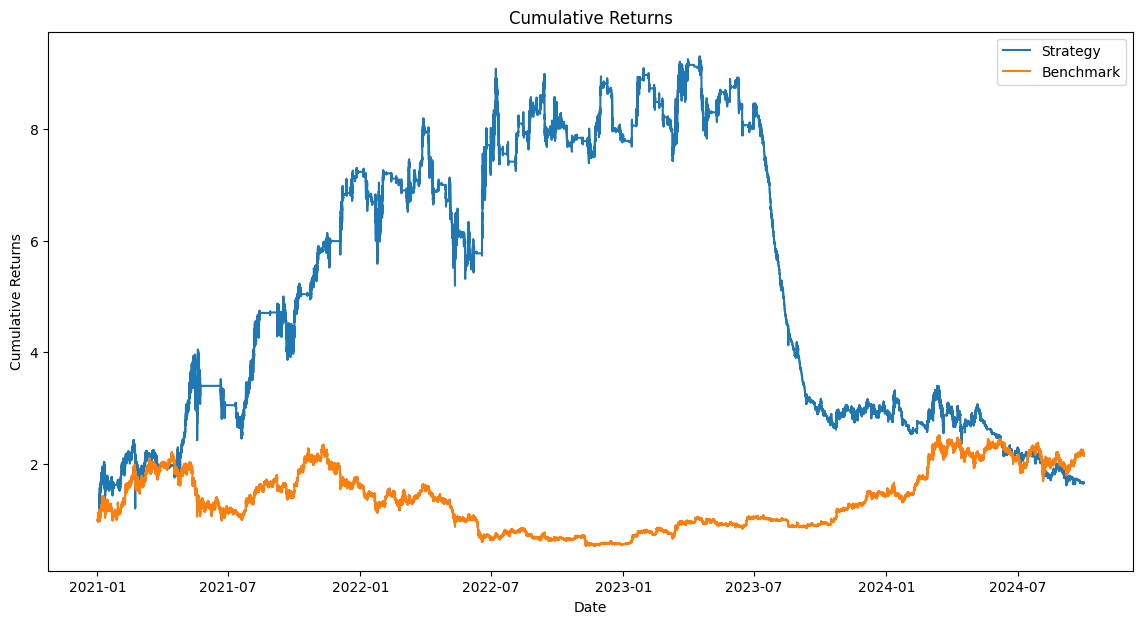

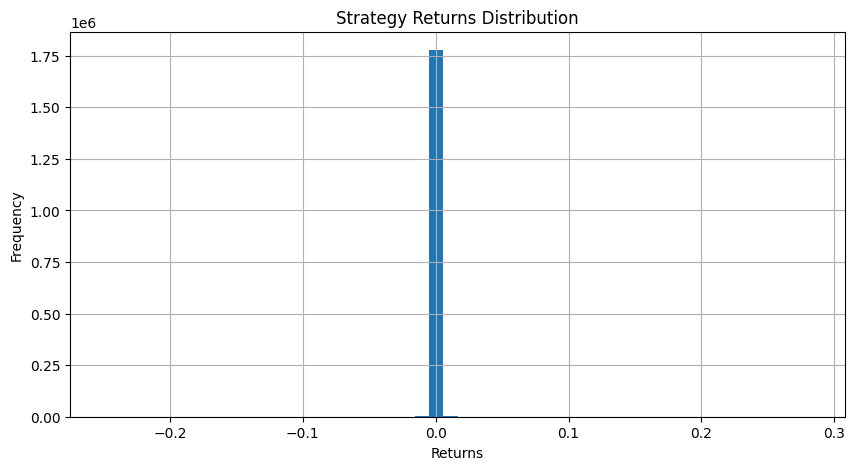

,Strategy,Benchmark
Metric,,
Total Return,66.73%,115.30%
Annualized Return,14.62%,22.71%
Number of Transactions,2986,N/A
Average Gain/Loss per Transaction,"$2,239.78",N/A
Maximum Drawdown,-82.63%,-77.49%
Annualized Sharpe Ratio,0.56,0.67
Tracking Error,65.39%,N/A
Information Ratio,-0.10,N/A
Treynor Ratio,0.72,N/A


In [ ]:
# Define strategy parameters
strategy_params = {
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'use_limit_orders': False,  # Set to True to use limit orders
    'limit_order_buffer': 0.001,
    'limit_order_duration': 5  # Number of ticks limit orders remain active
}

# Simulate the strategy
df_with_results, performance_metrics, trade_history = simulate_simple_trading_strategy(
    df=trading_df,
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


### OOS Only

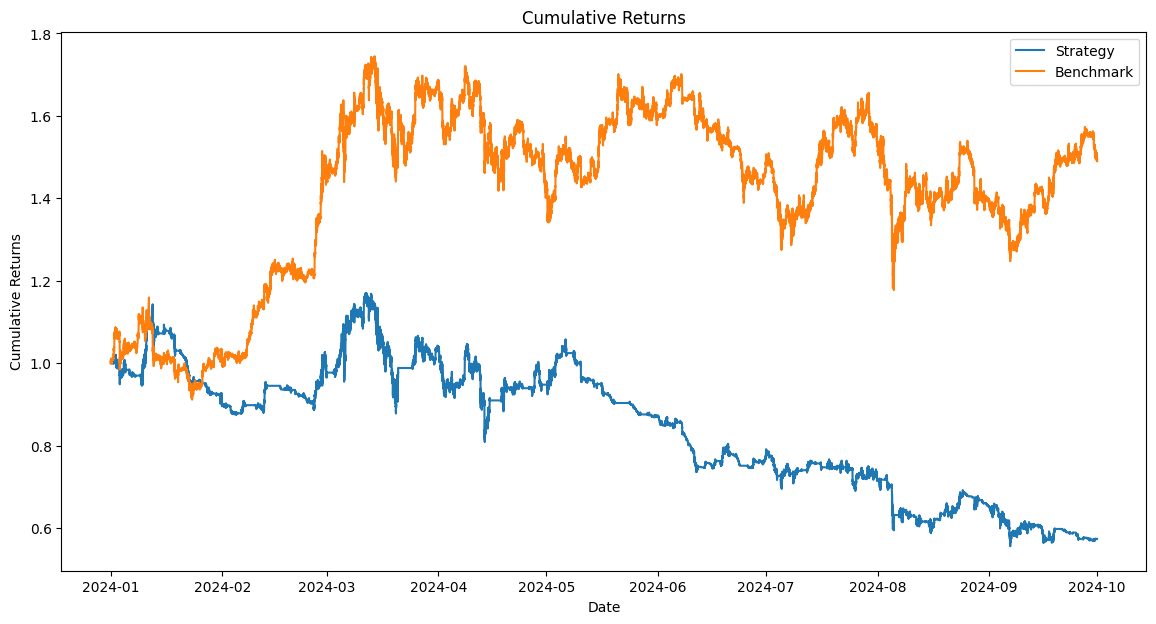

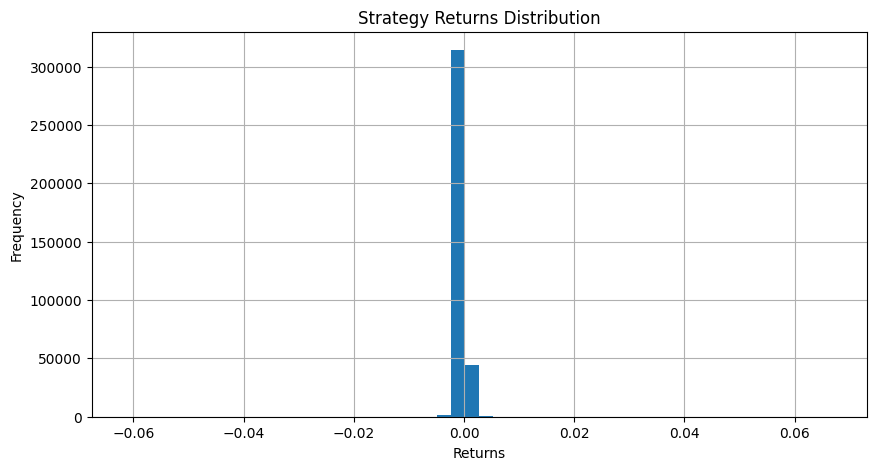

,Strategy,Benchmark
Metric,,
Total Return,-42.63%,49.58%
Annualized Return,-52.32%,71.04%
Number of Transactions,856,N/A
Average Gain/Loss per Transaction,"$-4,974.07",N/A
Maximum Drawdown,-52.49%,-32.50%
Annualized Sharpe Ratio,-1.62,1.43
Tracking Error,46.25%,N/A
Information Ratio,-3.07,N/A
Treynor Ratio,-1.55,N/A


In [ ]:
# Define strategy parameters
strategy_params = {
    'buy_threshold': 0.65,
    'sell_threshold': 0.35,
    'use_limit_orders': False,  # Set to True to use limit orders
    'limit_order_buffer': 0.001,
    'limit_order_duration': 5  # Number of ticks limit orders remain active
}

# Simulate the strategy
df_with_results, performance_metrics, trade_history = simulate_simple_trading_strategy(
    df=trading_df[trading_df.index >= '2024-01-01'],
    initial_capital=10_000_000,
    transaction_cost=0.001,
    strategy_params=strategy_params
)

# Analyze the strategy
metrics_df = analyze_strategies(df_with_results)

# Display the metrics
metrics_df


In [ ]:
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Define the hyperparameter grid
investment_fractions = [0.5, 0.75]  # Fraction of capital to invest
use_limit_orders_options = [True]  # Whether to use limit orders
buy_thresholds = [0.6, 0.65]          # Probability threshold to buy
sell_thresholds = [0.35, 0.4]         # Probability threshold to sell
limit_order_buffers = [0.00001]      # Price buffer for limit orders (e.g., 0.1%, 0.2%)
limit_order_durations = [5, 10]           # Duration in minutes for limit orders

# Collect results
results = []

# Create all combinations of hyperparameters
hyperparameter_combinations = list(product(
    investment_fractions,
    use_limit_orders_options,
    buy_thresholds,
    sell_thresholds,
    limit_order_buffers,
    limit_order_durations
))

print(f"Total combinations to evaluate: {len(hyperparameter_combinations)}")

i = 0
for params in hyperparameter_combinations:
    i+=1
    print(i)
    inv_frac, use_limit, buy_thres, sell_thres, limit_buffer, limit_duration = params
    
    # Ensure that buy_threshold > sell_threshold
    if buy_thres <= sell_thres:
        continue
    
    # Define strategy parameters
    strategy_params = {
        'investment_fraction': inv_frac,
        'use_limit_orders': use_limit,
        'buy_threshold': buy_thres,
        'sell_threshold': sell_thres,
        'limit_order_buffer': limit_buffer,
        'limit_order_duration': limit_duration
    }
    
    # Simulate the trading strategy
    df_with_results, performance_metrics, _ = simulate_trading_strategy(
        df=trading_df,
        target_variable='BTC_Future_Direction_5m',  # Change as needed
        initial_capital=10_000_000,
        transaction_cost=0.001,
        strategy_params=strategy_params
    )
    
    # Analyze the strategy
    df_with_results['Position'] = pd.to_numeric(df_with_results['Position'], errors='coerce')
    df_with_results['Pos_Benchmark'] = pd.to_numeric(df_with_results['Pos_Benchmark'], errors='coerce')
    df_with_results['Strategy_Returns'] = df_with_results['Position'].pct_change()
    df_with_results['Benchmark_Returns'] = df_with_results['Pos_Benchmark'].pct_change()
    
    # Calculate performance metrics
    strategy_metrics = calculate_metrics(df_with_results.copy(), 'Strategy_Returns', 'Benchmark_Returns')
    
    # Store the performance metrics and parameters
    result = {
        'Investment Fraction': inv_frac,
        'Use Limit Orders': use_limit,
        'Buy Threshold': buy_thres,
        'Sell Threshold': sell_thres,
        'Limit Order Buffer': limit_buffer,
        'Limit Order Duration': limit_duration,
        'Total Return (%)': strategy_metrics['Total Return'],
        'Annualized Return (%)': strategy_metrics['Annualized Return'],
        'Sharpe Ratio': strategy_metrics['Annualized Sharpe Ratio'],
        'Maximum Drawdown (%)': strategy_metrics['Maximum Drawdown'],
        'Number of Transactions': strategy_metrics['Number of Transactions']
    }
    results.append(result)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Convert percentage strings to floats for sorting
results_df['Total Return (%)'] = results_df['Total Return (%)'].str.rstrip('%').astype('float') / 100.0
results_df['Annualized Return (%)'] = results_df['Annualized Return (%)'].str.rstrip('%').astype('float') / 100.0
results_df['Maximum Drawdown (%)'] = results_df['Maximum Drawdown (%)'].str.rstrip('%').astype('float') / 100.0
results_df['Sharpe Ratio'] = results_df['Sharpe Ratio'].astype('float')

# Find the best performing strategy based on Total Return
best_strategy = results_df.loc[results_df['Total Return (%)'].idxmax()]

print("\nBest Strategy Parameters:")
print(best_strategy)

# Optionally, display the top N strategies
top_n = 5
print(f"\nTop {top_n} Strategies:")
print(results_df.sort_values(by='Total Return (%)', ascending=False).head(top_n))
